# Проект по разработке модели предсказания ДТП для каршеринговой компании.

### Цели исследования

- Разработать модель для предсказания ДТП на выбранном пользователем маршруте.

- Выявит основные причины причина возникновения ДТП на всех собранных данных.

### Ход исследования

- Подключение к базе данных заказчика.


- Первичное ознакомление с таблицами в SQL-базе данных.


- Статистический анализ факторов ДТП с целью выявить месяцы в которые происходит наибольшее количество аварий. 


- Составить план и пути решения поставленной задачи на основании доступных данных.


- Формирование обучающего датасета из данных заказчика.


- Построение и тестирование моделей разных типов.


- Анализ работы лучшей модели и выявление основных причин возникновения ДТП.


- Финальный вывод и рекомендации по улучшению каршериногового сервиса.


## Техническая секция

### Импорты библиотек

In [350]:
import pandas as pd
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
import time
import math
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from category_encoders import TargetEncoder, CountEncoder
from sklearn.metrics import fbeta_score
from category_encoders import BinaryEncoder
from sklearn.model_selection import cross_validate
from sqlalchemy import create_engine
from lightgbm import LGBMClassifier
from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

### Определение констант

In [351]:
RS = 42
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


### Подключение кастомных функций

In [352]:
def df_info(df, name="df"):
    """
    Выводит информацию о DataFrame: info(), describe() и первые 10 строк
    
    Parameters:
    df (pd.DataFrame): DataFrame для анализа
    name (str): имя DataFrame для отображения (по умолчанию "df")
    """
    print(f"=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ '{name}' ===")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print()
    
    print("1. ИНФОРМАЦИЯ О ДАННЫХ (info()):")
    display(df.info())
    print()
    
    print("2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):")
    display(df.describe().T)
    print()
    
    print("3. ПЕРВЫЕ 10 СТРОК:")
    display(df.head(10))
    print("="*60)

In [353]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

## Ознакомление с SQL базой заказчика.

Используем данные полученные от заказчика для авторизации в базе данных.

In [354]:
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-vehicle-db'
}

При помощи библиотеки SQLalchemy , инициируем подключение для дальнейшей выгрузки данных.

In [355]:
connection = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection)

In [356]:
try:
    with engine.connect() as conn:
        print("✅ Подключение к базе данных успешно!")
        
        # Получаем список таблиц
        tables = pd.read_sql("""
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_schema = 'public'
        """, conn)
        print("Доступные таблицы:")
        print(tables)
        
except Exception as e:
    print(f"❌ Ошибка подключения: {e}")

✅ Подключение к базе данных успешно!
Доступные таблицы:
   table_name
0    case_ids
1  collisions
2     parties
3    vehicles


Посмотрим на наполненность базы данных и оценим возможность использования ключа *CASE_ID* для формирования единого датасета.

In [357]:
queries = {
    'record_counts': """
        SELECT 'case_ids' as table_name, COUNT(*) as records FROM case_ids
        UNION ALL SELECT 'vehicles', COUNT(*) FROM vehicles
        UNION ALL SELECT 'collisions', COUNT(*) FROM collisions
        UNION ALL SELECT 'parties', COUNT(*) FROM parties
        """,
        
    'case_id_relationships': """
        SELECT 'case_ids' as metric, COUNT(DISTINCT case_id) as value FROM case_ids
        UNION ALL SELECT 'vehicles', COUNT(DISTINCT case_id) FROM vehicles
        UNION ALL SELECT 'collisions', COUNT(DISTINCT case_id) FROM collisions
        UNION ALL SELECT 'parties', COUNT(DISTINCT case_id) FROM parties
        """
}

results = {}

for name, query in queries.items():
    print(f"=== {name.upper().replace('_', ' ')} ===")
    results[name] = pd.read_sql(query, engine)
    display(results[name])
    print()

record_counts_df = results['record_counts']
relationships_df = results['case_id_relationships']

=== RECORD COUNTS ===


table_name  records
0    vehicles  1021234
1    case_ids  1400000
2  collisions  1400000
3     parties  2752408


=== CASE ID RELATIONSHIPS ===


metric    value
0    vehicles   792642
1    case_ids  1400000
2  collisions  1400000
3     parties  1400000

Для наглядности отобразим графики полученных значений.

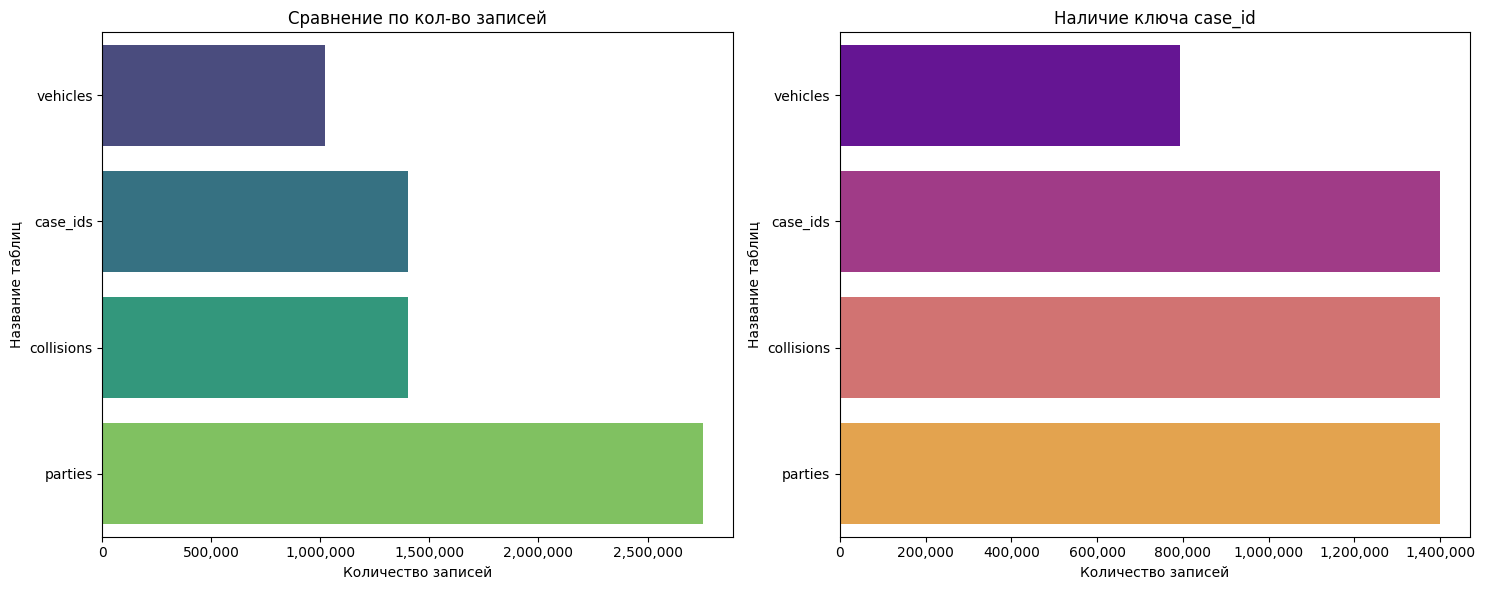

In [358]:
warnings.filterwarnings("ignore", category=FutureWarning)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Первый график
sns.barplot(data=record_counts_df, y='table_name', x='records', ax=ax1, palette='viridis')
ax1.set_title('Сравнение по кол-во записей')
ax1.set_xlabel('Количество записей')
ax1.set_ylabel('Название таблиц')
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Второй график
sns.barplot(data=relationships_df, y='metric', x='value', ax=ax2, palette='plasma')
ax2.set_title('Наличие ключа case_id')
ax2.set_xlabel('Количество записей')
ax2.set_ylabel('Название таблиц')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

### Вывод

- Мы подключились к базе данных заказчика и обнаружили следующие :
    
    
    * Данных в таблицах достаточно для выполнения поставленной заказчиком задачи , а именно имеется следующие кол-во записей в таблицах.

       * **vehicles**  -  1021234
       * **case_ids**  -  1400000
       * **collisions**  -  14000000
       * **parties**  -   2752408


- Так же мы удостоверились в возможности объединения таблиц , проверив количественное наличие ключа **case_id** в каждой из них.


## Cтатистический анализ факторов ДТП

**Выясним, в какие месяцы происходит наибольшее количество аварий**

Получим статистику по месяцам с привязкой к году и посмотрим удастся ли сделать какие либо выводы.

In [359]:
query = """
SELECT 
    TO_CHAR(DATE(collision_date), 'YYYY-MM') AS year_month,
    COUNT(DISTINCT c.case_id) AS cnt
FROM collisions c 
GROUP BY 
    TO_CHAR(DATE(collision_date), 'YYYY-MM')
ORDER BY 
    year_month;
"""

In [360]:
df_date_graph = pd.read_sql(query, engine)

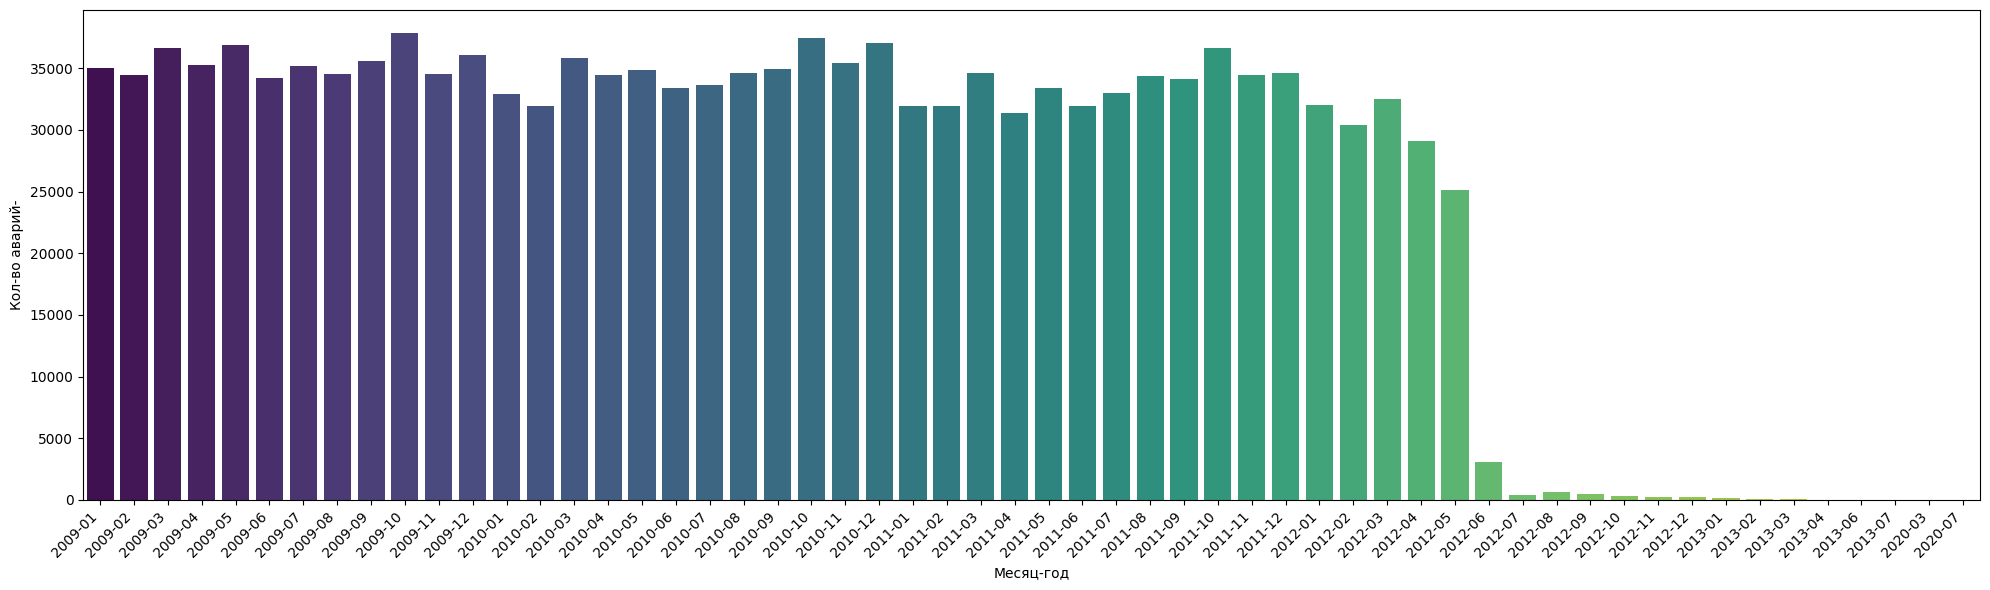

In [361]:
plt.subplots(figsize=(20, 6))
sns.barplot(data=df_date_graph, y='cnt', x='year_month', palette='viridis', orient='v')
plt.xticks(rotation=45, ha='right')  
plt.ylabel('Кол-во аварий-')
plt.xlabel('Месяц-год')
plt.tight_layout()

Видим что кол-во аварий начиная с *2012-05* резко начало падать.

Получим статистику по количеству ДТП в разрезе года представленного в данных.

In [362]:
query = """
SELECT 
    extract('year' from c.collision_date) as year,
    COUNT(DISTINCT c.case_id) AS cnt
FROM collisions c 
GROUP BY 
    extract('year' from c.collision_date)
ORDER BY 
    year;
"""

In [363]:
pd.read_sql(query, engine) 

year     cnt
0  2009.0  426228
1  2010.0  416490
2  2011.0  402428
3  2012.0  154547
4  2013.0     305
5  2020.0       2

Видим аномальные данные начиная с 2013г. Отсутствие данных с периода 2013г. по 2020г. указывает на ошибку в базе данных , или же на то что в компании было внедрено действенное средство для уменьшения кол-ва ДТП.

Возьмем за основу предположение об ошибке в данных начиная с 2013г. , так как версия о том что в этот период удалось достичь настолько резкого снижения уровня аварий не видится правдоподобной.

На основании выдвинутой гипотезы , уберем из анализа данные после 2012г.

In [364]:
query = """
SELECT 
    extract('month' from c.collision_date) as month,
    COUNT(DISTINCT c.case_id) AS cnt
FROM collisions c 
where extract('year' from c.collision_date) < 2013
GROUP BY 
    extract('month' from c.collision_date)
ORDER BY 
    month;
"""

In [365]:
df_month_graph = pd.read_sql(query, engine) 

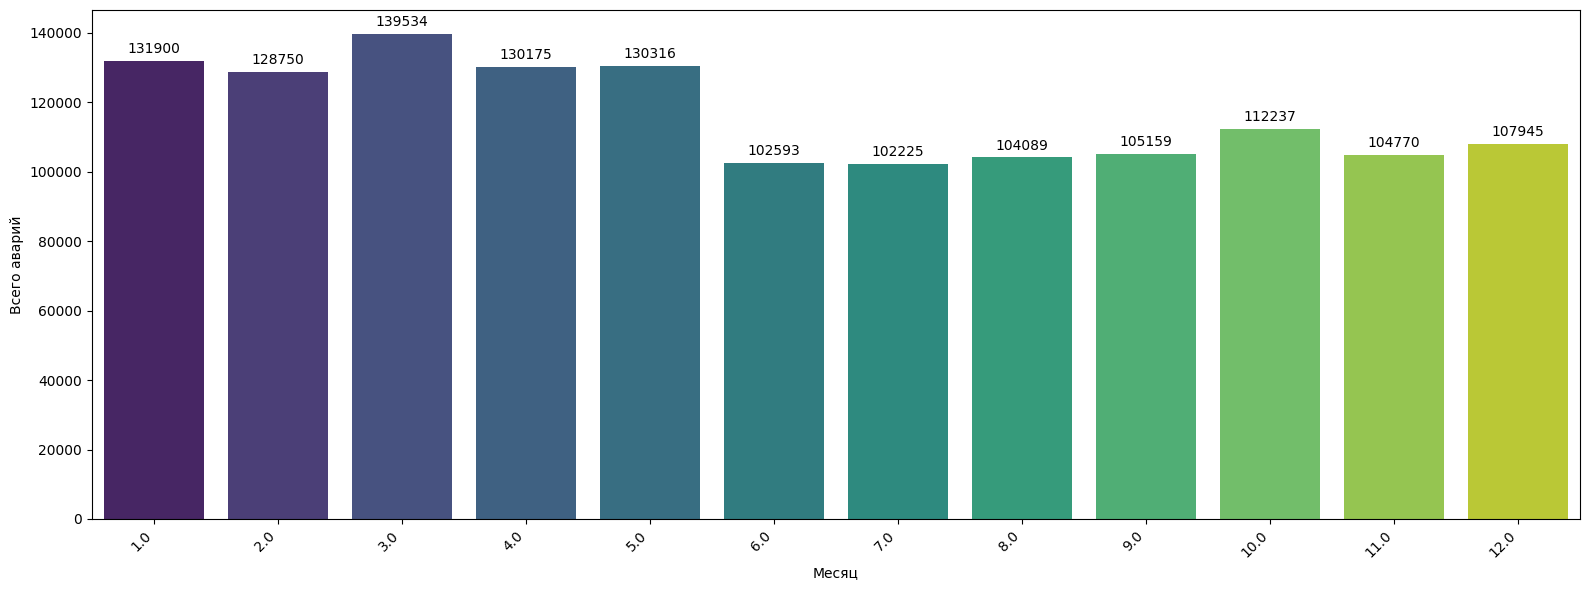

In [366]:
plt.subplots(figsize=(16, 6))
ax = sns.barplot(data=df_month_graph, y='cnt', x='month', palette='viridis', orient='v')

for i, v in enumerate(df_month_graph['cnt']):
    ax.text(i, v + 0.01 * max(df_month_graph['cnt']), 
            f'{v:.0f}', 
            ha='center', va='bottom', 
            fontsize=10)

plt.xticks(rotation=45, ha='right')  
plt.ylabel('Всего аварий')
plt.xlabel('Месяц')
plt.tight_layout()
plt.show()

### Вывод

- Анализ данных демонстрирует выраженную сезонную зависимость уровня аварийности. Наибольшее количество ДТП регистрируется в осенне-зимний период, тогда как весенне-летний их число снижается, что, вероятно, обусловлено менее благоприятными погодными условиями и состоянием дорожного покрытия.

## Анализ зависимостей между факторами и количеством ДТП.

Сформулируем несколько направлений для исследования причинности аварий с другими имеющимися у нас данными.

- Построить рейтинг самых аварийных городов/районов (county_city_location, county_location). Проанализировать распределение ДТП по типам локаций (location_type — например, перекресток, шоссе) и наличию светофоров (control_device).
 

- Какие географические зоны и типы дорог являются наиболее рискованными? Можно ли использовать эти данные для привязки к маршруту?


- Проанализировать распределение ДТП по времени суток (collision_time), дням недели и месяцам (collision_date). Исследовать связь между условиями (weather_1, road_surface, road_condition_1, lighting) и частотой ДТП.



- Определить топ-5 самых распространенных первичных причин ДТП (primary_collision_factor) и категорий нарушений (pcf_violation_category). Проанализировать самые частые типы столкновений (type_of_collision).



-  Проверить, связан ли тип трансмиссии (vehicle_transmission) или возраст автомобиля (vehicle_age) с частотой попадания в ДТП или с типом нарушения.


- Проанализировать взаимосвязь между состоянием трезвости водителей(party_sobriety) и основными факторами столкновений(primary_collision_factor). Исследовать, как распределяются причины ДТП в зависимости от физического состояния участников дорожного движения.


### Анализ на основании трезвости водителя.

Возьмем в работу один из обозначенных пунктов , а именно как состояние трезвости влияет на первичную причину аварии.

In [367]:
query = """
SELECT
    p.party_sobriety,
    c.primary_collision_factor,
    COUNT(c.case_id) as accident_count
FROM parties p 
LEFT JOIN collisions c ON p.case_id = c.case_id and p.party_number=c.party_count
WHERE 
    p.party_sobriety IS NOT NULL 
    AND c.primary_collision_factor IS NOT NULL
GROUP BY 
    p.party_sobriety, 
    c.primary_collision_factor
ORDER BY 
    accident_count DESC;
"""

In [368]:
df_sober_factor = pd.read_sql(query, engine)

Для удобства восприятия , отобразим полученные результаты в матрице с тепловой картой.

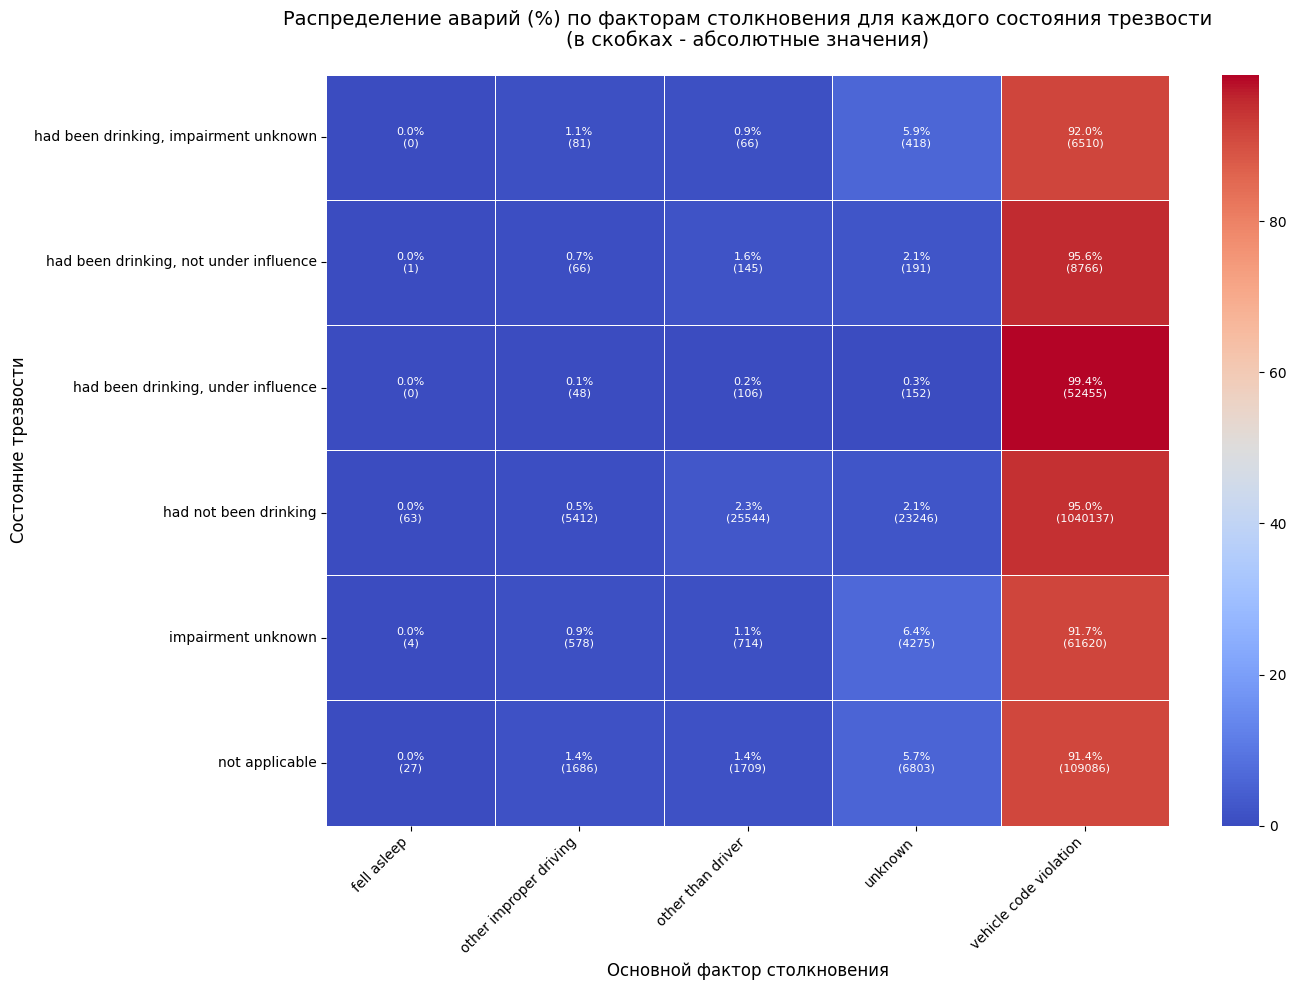

In [369]:
pivot_df = df_sober_factor.pivot_table(
    index='party_sobriety', 
    columns='primary_collision_factor', 
    values='accident_count',
    fill_value=0
)

pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

annot_matrix = []
for i in range(pivot_pct.shape[0]):
    row_annotations = []
    for j in range(pivot_pct.shape[1]):
        percentage = pivot_pct.iloc[i, j]
        absolute = pivot_df.iloc[i, j]
        annotation = f"{percentage:.1f}%\n({absolute:.0f})"
        row_annotations.append(annotation)
    annot_matrix.append(row_annotations)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_pct, annot=annot_matrix, fmt='', cmap='coolwarm', linewidths=0.5,
            annot_kws={'size': 8, 'ha': 'center', 'va': 'center'})
plt.title('Распределение аварий (%) по факторам столкновения для каждого состояния трезвости\n(в скобках - абсолютные значения)', 
          fontsize=14, pad=20)
plt.xlabel('Основной фактор столкновения', fontsize=12)
plt.ylabel('Состояние трезвости', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<span style="font-size:30px">**Вывод :**</span>

- Во всех рассмотренных категориях преобладает такой фактор как **vehicle_code_violation** *Нарушение правил ПДД*.

- Так же процент в группе **had been drinking, under influence** по нарушению ПДД достигает **99.4%** , что указывает на явную корреляцию между ними.

### Исследование возраста авто и типа полученных повреждений.

Так же попытаемся установить есть ли взаимосвязь между возрастом автомобиля кол-вом и типом повреждений при ДТП.

In [370]:
query = """
SELECT
    v.vehicle_age as age,
    COUNT(c.case_id) as accident_count
FROM vehicles v
LEFT JOIN collisions c ON v.case_id = c.case_id and v.party_number=c.party_count
WHERE 
    v.vehicle_age IS NOT NULL and v.vehicle_age <= 20
GROUP BY 
    v.vehicle_age
ORDER BY 
    age;
"""

In [371]:
df_age = pd.read_sql(query, engine)

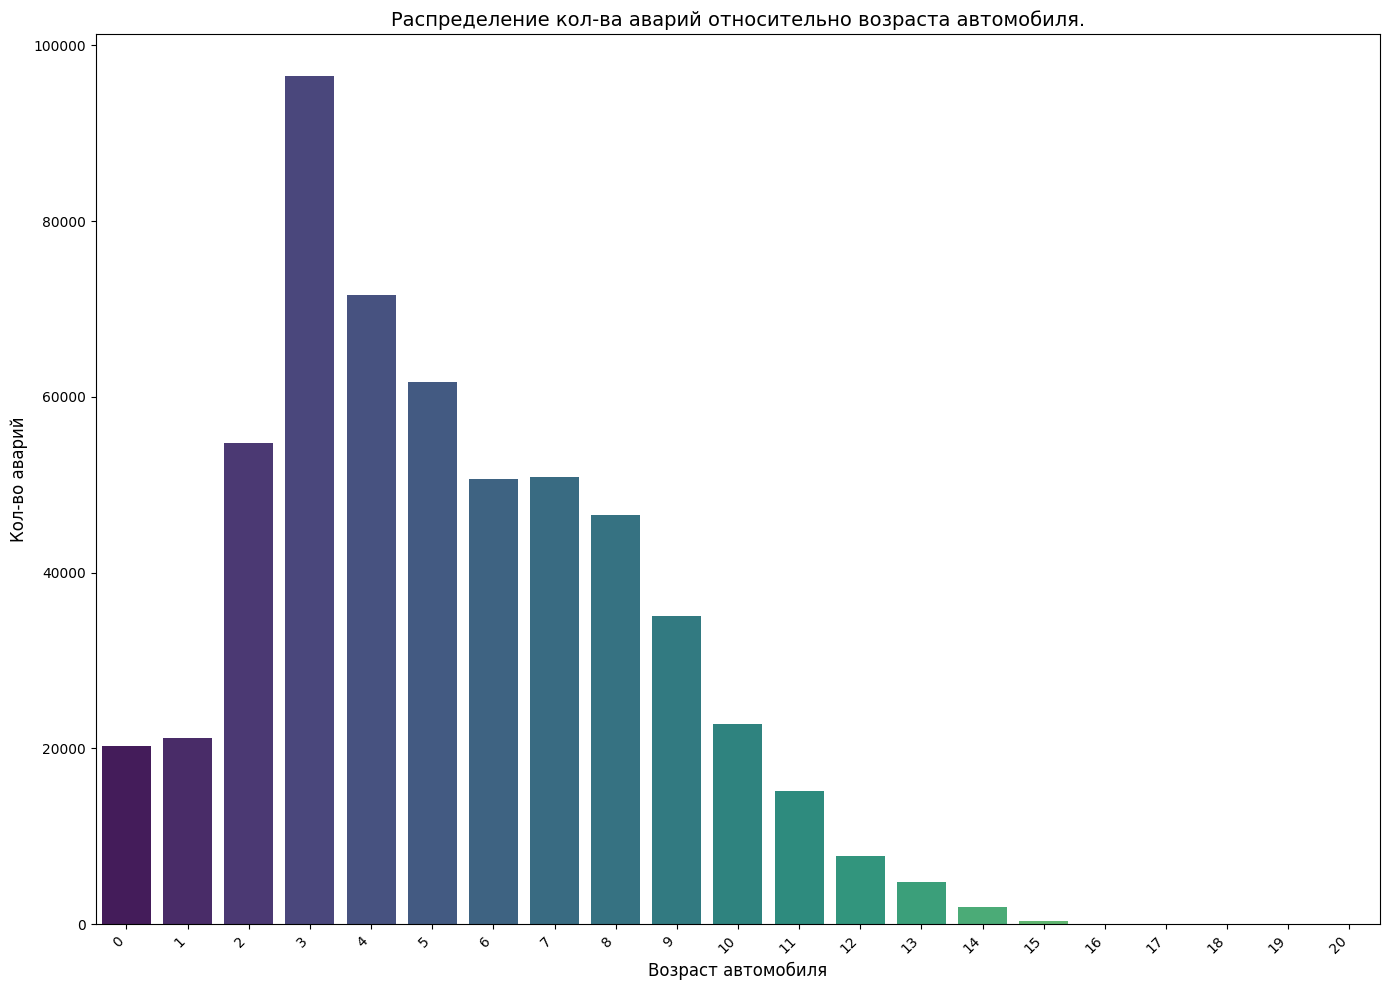

In [372]:
plt.figure(figsize=(14, 10))
sns.barplot(data=df_age, y='accident_count', x='age', palette='viridis', orient='v')
plt.title('Распределение кол-ва аварий относительно возраста автомобиля.', fontsize=14)
plt.xlabel('Возраст автомобиля', fontsize=12)
plt.ylabel('Кол-во аварий', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Рассмотрим повреждения авто в разрезе возраста автомобиля.

In [373]:
query = """
SELECT
    v.vehicle_age as age,
    c.COLLISION_DAMAGE as dmg,
    COUNT(*) as accident_count
FROM vehicles v
LEFT JOIN collisions c ON v.case_id = c.case_id and v.party_number=c.party_count
WHERE 
    v.vehicle_age IS NOT NULL and c.COLLISION_DAMAGE IS NOT NULL and v.vehicle_age <= 20
GROUP BY 
    v.vehicle_age,
    c.COLLISION_DAMAGE
ORDER BY 
    age;
"""

In [374]:
df_dmg_age = pd.read_sql(query, engine)

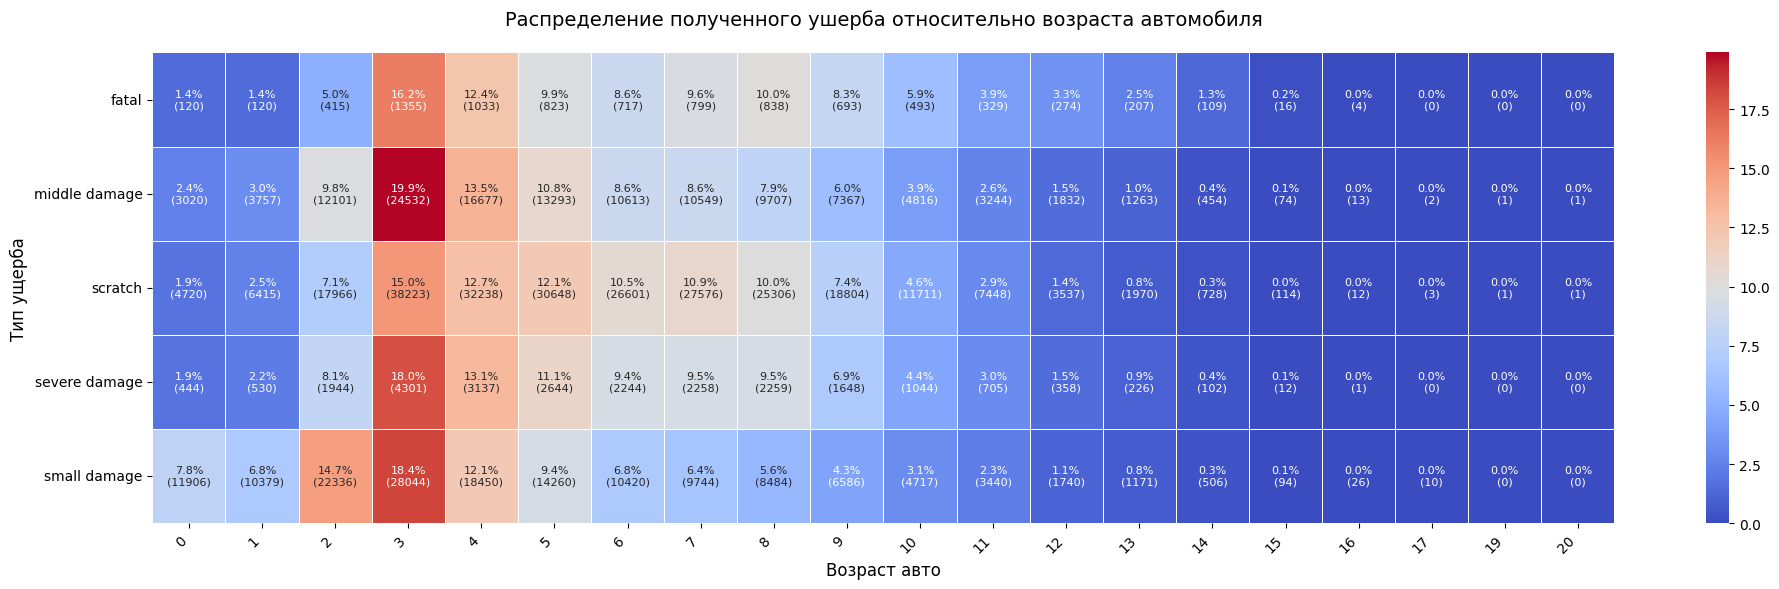

In [375]:
pivot_df = df_dmg_age.pivot_table(
    index='dmg',  
    columns='age',  
    values='accident_count',
    fill_value=0
)

pivot_pct = (pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100)

annot_matrix = []
for i in range(pivot_pct.shape[0]):
    row_annotations = []
    for j in range(pivot_pct.shape[1]):
        percentage = pivot_pct.iloc[i, j]
        absolute = pivot_df.iloc[i, j]
        annotation = f"{percentage:.1f}%\n({absolute:.0f})"
        row_annotations.append(annotation)
    annot_matrix.append(row_annotations)

plt.figure(figsize=(20, 6))
sns.heatmap(pivot_pct, annot=annot_matrix, fmt='', cmap='coolwarm', linewidths=0.5,
            annot_kws={'size': 8, 'ha': 'center', 'va': 'center'})
plt.title('Распределение полученного ушерба относительно возраста автомобиля', fontsize=14, pad=20)
plt.xlabel('Возраст авто', fontsize=12)
plt.ylabel('Тип ущерба', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

<span style="font-size:30px">**Вывод :**</span>

- При выгрузке из базы заказчика в переменной **vehicle_age** замечена аномалия , а именно значение в 161 что является явной опечаткой. При нашей дальнейшей работе мы изолировали это значение , ограничившись значениями до 20лет включительно.

- Из проведенного исследования видна явная корреляция ДТП и повреждений с авто возрастом *3-5лет*. Возможно что основная часть автопарка сервиса представлена машинами этого возраста и корреляция ни как не связана с их техническим состоянием.

- Так как в базе нет данных об уникальных id автомобилей какого либо явного заключения  , сделать не удается.

### Вывод по блоку

- Мы сформулировали и определили дальнейшие шаги для нашей команды по разработке сервиса по предсказанию ДТП.


- Лично провели исследование двух пунктов из нашего списка и установили следующие :
    

    * Опечатка в переменной *vehicle_age*
    
    
    * В группе людей употребивших алкоголь нарушение ПДД является практически 100%. Что указывает на явную корреляцию относительно других освещенных нами групп.


    * Так же при анализе возраста автомобилей причин и тяжести повреждений, наметилась зависимость для автомобилей возрастом *3-5 лет*. Так как у нас нет информации об автопарке заказчика , оставим это наблюдение без явного вывода.

## Подготовка датасета

### Выгрузка данных из базы.

In [376]:
query = """
SELECT 
    p.id,
    p.case_id,
    p.party_number,
    p.at_fault,
    v.vehicle_age,
    v.vehicle_type,
    v.vehicle_transmission,
    c.county_location,
    c.county_city_location,	
    c.distance,
    c.direction,
    c.intersection,
    c.weather_1,
    c.location_type,
    c.primary_collision_factor,
    c.pcf_violation_category,
    c.type_of_collision,
    c.motor_vehicle_involved_with,
    c.road_surface,
    c.road_condition_1,
    c.lighting,
    c.control_device,
    c.collision_time,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    p.insurance_premium,
    c.collision_damage
FROM parties p
INNER JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
INNER JOIN collisions c ON p.case_id = c.case_id
INNER JOIN case_ids ci ON p.case_id = ci.case_id
WHERE p.party_type = 'car'
    AND c.collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM c.collision_date) = 2012
    AND v.vehicle_age IS NOT NULL
    """

df = pd.read_sql(query, engine)

print(f"Загружено {len(df)} строк")
print(df.info())


Загружено 54554 строк
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54554 non-null  int64  
 1   case_id                      54554 non-null  object 
 2   party_number                 54554 non-null  int64  
 3   at_fault                     54554 non-null  int64  
 4   vehicle_age                  54554 non-null  int64  
 5   vehicle_type                 54554 non-null  object 
 6   vehicle_transmission         53979 non-null  object 
 7   county_location              54554 non-null  object 
 8   county_city_location         54554 non-null  object 
 9   distance                     54554 non-null  float64
 10  direction                    42097 non-null  object 
 11  intersection                 54386 non-null  float64
 12  weather_1                    54389 non-null  object 

In [377]:
df.collision_damage.value_counts()

collision_damage
small damage     29237
middle damage    19068
severe damage     3491
fatal             2758
Name: count, dtype: int64

Видим что выгруженные данные соответствуют требованию заказчика.

In [378]:
df.head(5)

id  case_id  party_number  at_fault  vehicle_age vehicle_type  \
0  2659603  5600885             1         1            8        sedan   
1  2672839  5608728             1         0            5        sedan   
2  2673091  5608860             2         0            0        sedan   
3  2674405  5609619             1         1            1        sedan   
4  2678982  5612084             2         0            0        sedan   

  vehicle_transmission county_location county_city_location  distance  ...  \
0                 auto  san bernardino                 3607     400.0  ...   
1                 auto         alameda                 0109     500.0  ...   
2                 auto     santa clara                 4303     160.0  ...   
3                 auto     los angeles                 1949      16.0  ...   
4                 auto  san bernardino                 3600      40.0  ...   

  road_surface  road_condition_1                 lighting control_device  \
0          dry            normal  dark with street lights           none   
1          dry            normal             dusk or dawn           none   
2          dry            normal                 daylight           none   
3          dry            normal                 daylight    functioning   
4          dry            normal                 daylight    functioning   

  collision_time         party_sobriety   party_drug_physical  \
0       22:04:00  had not been drinking                  None   
1       18:00:00  had not been drinking                  None   
2       11:32:00  had not been drinking                  None   
3       08:10:00                   None  under drug influence   
4       17:40:00  had not been drinking                  None   

  cellphone_in_use insurance_premium collision_damage  
0              0.0              43.0     small damage  
1              0.0              41.0     small damage  
2              0.0              28.0     small damage  
3              0.0              44.0     small damage  
4              0.0              34.0     small damage  

[5 rows x 28 columns]

### Разведывательный анализ данных

In [379]:
df_info(df, 'car_crash')

=== ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ 'car_crash' ===
Размер: 54554 строк, 28 столбцов

1. ИНФОРМАЦИЯ О ДАННЫХ (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54554 non-null  int64  
 1   case_id                      54554 non-null  object 
 2   party_number                 54554 non-null  int64  
 3   at_fault                     54554 non-null  int64  
 4   vehicle_age                  54554 non-null  int64  
 5   vehicle_type                 54554 non-null  object 
 6   vehicle_transmission         53979 non-null  object 
 7   county_location              54554 non-null  object 
 8   county_city_location         54554 non-null  object 
 9   distance                     54554 non-null  float64
 10  direction                    42097 non-null  object 
 11  intersection         

None


2. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (describe().T):


count          mean           std        min        25%  \
id                 54554.0  2.594730e+06  98844.968721  1800807.0  2517495.0   
party_number       54554.0  1.527514e+00      0.664262        1.0        1.0   
at_fault           54554.0  5.048392e-01      0.499981        0.0        0.0   
vehicle_age        54554.0  4.856472e+00      3.234503        0.0        3.0   
distance           54554.0  8.761480e+02   7348.699248        0.0        9.0   
intersection       54386.0  2.186592e-01      0.413341        0.0        0.0   
cellphone_in_use   50384.0  2.024452e-02      0.140837        0.0        0.0   
insurance_premium  54135.0  3.762703e+01     16.349592        0.0       24.0   

                         50%         75%        max  
id                 2598449.0  2681257.50  2752381.0  
party_number             1.0        2.00        9.0  
at_fault                 1.0        1.00        1.0  
vehicle_age              4.0        7.00      161.0  
distance               143.0      575.75  1584000.0  
intersection             0.0        0.00        1.0  
cellphone_in_use         0.0        0.00        1.0  
insurance_premium       34.0       49.00      105.0


3. ПЕРВЫЕ 10 СТРОК:


id  case_id  party_number  at_fault  vehicle_age vehicle_type  \
0  2659603  5600885             1         1            8        sedan   
1  2672839  5608728             1         0            5        sedan   
2  2673091  5608860             2         0            0        sedan   
3  2674405  5609619             1         1            1        sedan   
4  2678982  5612084             2         0            0        sedan   
5  2690979  5618760             2         0            4        sedan   
6  2691195  5618865             1         1            6        sedan   
7  2708011  5627901             1         1            2        sedan   
8  2715449  5632134             1         1            6        sedan   
9  2719110  5634112             2         0            6        sedan   

  vehicle_transmission county_location county_city_location  distance  ...  \
0                 auto  san bernardino                 3607     400.0  ...   
1                 auto         alameda                 0109     500.0  ...   
2                 auto     santa clara                 4303     160.0  ...   
3                 auto     los angeles                 1949      16.0  ...   
4                 auto  san bernardino                 3600      40.0  ...   
5                 auto     los angeles                 1949     150.0  ...   
6                 auto     los angeles                 1900     137.0  ...   
7                 auto      sacramento                 3400      46.0  ...   
8                 auto          orange                 3016       0.0  ...   
9                 auto     san joaquin                 3906      48.0  ...   

  road_surface  road_condition_1                 lighting control_device  \
0          dry            normal  dark with street lights           none   
1          dry            normal             dusk or dawn           none   
2          dry            normal                 daylight           none   
3          dry            normal                 daylight    functioning   
4          dry            normal                 daylight    functioning   
5          dry            normal                 daylight           none   
6          wet            normal                 daylight           none   
7          dry            normal                 daylight           none   
8          dry            normal  dark with street lights           none   
9          dry              None                 daylight    functioning   

  collision_time         party_sobriety   party_drug_physical  \
0       22:04:00  had not been drinking                  None   
1       18:00:00  had not been drinking                  None   
2       11:32:00  had not been drinking                  None   
3       08:10:00                   None  under drug influence   
4       17:40:00  had not been drinking                  None   
5       09:15:00  had not been drinking                  None   
6       11:55:00  had not been drinking                  None   
7       07:20:00  had not been drinking                  None   
8       20:53:00  had not been drinking                  None   
9       14:32:00  had not been drinking                  None   

  cellphone_in_use insurance_premium collision_damage  
0              0.0              43.0     small damage  
1              0.0              41.0     small damage  
2              0.0              28.0     small damage  
3              0.0              44.0     small damage  
4              0.0              34.0     small damage  
5              0.0              18.0     small damage  
6              0.0              32.0     small damage  
7              0.0              29.0     small damage  
8              0.0              45.0    middle damage  
9              0.0              23.0     small damage  

[10 rows x 28 columns]

In [380]:
ProfileReport(df.drop(['id', 'case_id'], axis=1), title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 26/26 [00:03<00:00,  8.49it/s]


In [381]:
check_data_dubmiss(df, 'car_crash')

Категория                     Параметр   Значение  \
0       Общая информация          Название датафрейма  car_crash   
1              Дубликаты             Всего дубликатов          0   
2              Дубликаты           Примеры дубликатов      False   
3   Пропущенные значения         vehicle_transmission        575   
4   Пропущенные значения                    direction      12457   
5   Пропущенные значения                 intersection        168   
6   Пропущенные значения                    weather_1        165   
7   Пропущенные значения                location_type      29043   
8   Пропущенные значения     primary_collision_factor         97   
9   Пропущенные значения       pcf_violation_category        721   
10  Пропущенные значения            type_of_collision        290   
11  Пропущенные значения  motor_vehicle_involved_with        147   
12  Пропущенные значения                 road_surface        329   
13  Пропущенные значения             road_condition_1        237   
14  Пропущенные значения                     lighting        152   
15  Пропущенные значения               control_device        206   
16  Пропущенные значения               collision_time         84   
17  Пропущенные значения               party_sobriety        836   
18  Пропущенные значения          party_drug_physical      51868   
19  Пропущенные значения             cellphone_in_use       4170   
20  Пропущенные значения            insurance_premium        419   
21              Пропуски   Всего пропущенных значений     101964   

                 Детали  
0   Размер : 54554 x 28  
1                        
2                        
3                 1.05%  
4                22.83%  
5                 0.31%  
6                 0.30%  
7                53.24%  
8                 0.18%  
9                 1.32%  
10                0.53%  
11                0.27%  
12                0.60%  
13                0.43%  
14                0.28%  
15                0.38%  
16                0.15%  
17                1.53%  
18               95.08%  
19                7.64%  
20                0.77%  
21  6.68% от всех ячеек

### Описание переменных датасета

| Название переменной | Тип данных | Описание |
|---------------------|------------|-----------|
| `id` | integer | **Индекс текущей таблицы** - уникальный идентификатор записи в таблице |
| `case_id` | integer | **Идентификационный номер в базе данных** - уникальный номер для зарегистрированного происшествия в таблице происшествий |
| `party_number` | integer | **Номер участника происшествия** - от 1 до N по числу участников происшествия |
| `at_fault` | integer | **Виновность участника** - бинарный показатель (0/1) |
| `vehicle_age` | integer | **Возраст автомобиля** - в годах |
| `vehicle_type` | categorical | **Тип кузова** - MINIVAN, COUPE, SEDAN, HATCHBACK, OTHER |
| `vehicle_transmission` | categorical | **Тип КПП** - auto (Автоматическая), manual (Ручная), - (Не указано) |
| `county_location` | categorical | **Названия географических районов** - список разных названий, категориальный тип данных |
| `county_city_location` | integer | **Номер географических районов** - число, идентифицирующее район где произошло ДТП |
| `distance` | numeric | **Расстояние от главной дороги** - в метрах |
| `direction` | categorical | **Направление движения** - N (Север), E (Восток), S (Юг), W (Запад), - (Не указано) |
| `intersection` | categorical | **Является ли место происшествия перекрёстком** - Y (Перекрёсток), N (Не перекрёсток), -- (Не указано) |
| `weather_1` | categorical | **Погода** - A (Ясно), B (Облачно), C (Дождь), D (Снегопад), E (Туман), F (Другое), G (Ветер), - (Не указано) |
| `location_type` | categorical | **Тип дороги** - H (Шоссе), I (Перекрёсток), R (Рампа), - (Не указано) |
| `primary_collision_factor` | categorical | **Основной фактор аварии** - A (Нарушение правил ПДД), B (Другое неправильное вождение), C (Кроме водителя), D (Неизвестно), E (Заснул), - (Не указано) |
| `pcf_violation_category` | categorical | **Категория нарушения** - 01-24 коды нарушений, 00 (Неизвестно), - (Не указано) |
| `type_of_collision` | categorical | **Тип аварии** - A (Лоб в лоб), B (Сторона), C (Столкновение задней частью), D (Боковой удар), E (Удар объекта), F (Опрокинутый), G (Транспортное средство/Пешеход), H (Другое), - (Не указано) |
| `motor_vehicle_involved_with` | categorical | **Дополнительные участники ДТП** - Other motor vehicle, Fixed object, Parked motor vehicle, Pedestrian, Bicycle, Non-collision, Other object, Motor vehicle on other roadway, Animal, Train |
| `road_surface` | categorical | **Состояние дороги** - A (Сухая), B (Мокрая), C (Заснеженная или обледенелая), D (Скользкая), - (Не указано) |
| `road_condition_1` | categorical | **Дорожное состояние** - A (Ямы, глубокая колея), B (Сыпучий материал), C (Препятствие), D (Зона строительства), E (Уменьшенная ширина), F (Затоплено), G (Другое), H (Нет ничего необычного), - (Не указано) |
| `lighting` | categorical | **Освещение** - A (Дневной свет), B (Сумерки-Рассвет), C (Темно-Уличные фонари), D (Темно-Нет уличных фонарей), E (Темно-Уличные фонари не работают), - (Не указано) |
| `control_device` | categorical | **Устройство управления** - (описание отсутствует в исходных данных) |
| `party_sobriety` | categorical | **Трезвость участника** - A (Не пил), B (Был пьян, под влиянием), C (Был пьян, не под влиянием), D (Был пьян, ухудшение неизвестно), G (Неизвестно ухудшение), H (Не оценивался), - (Не указано) |
| `party_drug_physical` | categorical | **Состояние участника: физическое или с учётом принятых лекарств** - E (Под воздействием лекарств), F (Ухудшение состояния), G (Не известно), H (Не оценивался), I (Сонный/Усталый), - (Не указано) |
| `cellphone_in_use` | integer | **Наличие телефона в автомобиле** - бинарный показатель (0/1) возможности разговаривать по громкой связи |
| `insurance_premium` | numeric | **Сумма страховки** - в тысячах долларов |

**Неописанные переменные**



<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>control_device</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>functioning</td>
    </tr>
    <tr>
      <th>1</th>
      <td>obscured</td>
    </tr>
    <tr>
      <th>2</th>
      <td>not functioning</td>
    </tr>
    <tr>
      <th>3</th>
      <td>None</td>
    </tr>
    <tr>
      <th>4</th>
      <td>none</td>
    </tr>
  </tbody>
</table>
</div>

По представленным значениям , переменна отражает установленный модуль контроля.

### Анализ переменной control_device

Посмотрим на то в каких годах началось применение *control_device*.

Возможно что внедрение этого устройство для сбора дополнительной информации о водителе , как то сказалось на кол-ве аварий.

In [382]:
query = """
SELECT 
    extract('year' from c.collision_date) as year,
    c.control_device as dev,
    COUNT(DISTINCT c.case_id) as unique_cases
FROM collisions c
GROUP BY extract('year' from c.collision_date), c.control_device;
"""

In [383]:
devices = pd.read_sql(query, engine) 

In [384]:
devices.head(10)

year              dev  unique_cases
0  2009.0      functioning        145598
1  2009.0             none        276760
2  2009.0  not functioning          1134
3  2009.0         obscured           192
4  2009.0             None          2544
5  2010.0      functioning        139599
6  2010.0             none        273047
7  2010.0  not functioning          1119
8  2010.0         obscured           215
9  2010.0             None          2510

In [385]:
devices.pivot(index='year', columns='dev', values='unique_cases')

dev        NaN  functioning      none  not functioning  obscured
year                                                            
2009.0  2544.0     145598.0  276760.0           1134.0     192.0
2010.0  2510.0     139599.0  273047.0           1119.0     215.0
2011.0  2477.0     134526.0  263976.0           1217.0     232.0
2012.0   876.0      51041.0  102177.0            363.0      90.0
2013.0     NaN         85.0     220.0              NaN       NaN
2020.0     NaN          NaN       2.0              NaN       NaN

<span style="font-size:30px">**Вывод :**</span>

- Видим что устройства применялись с самого начала ведения базы пользователей.

- Так как у нас отсутствует достоверное описание этого признака , в будущем исключим его из обучения.

### Предобработка

In [386]:
# ProfileReport(df.drop(['id', 'collision_time'], axis=1), title="Profiling Report", minimal=False, progress_bar=False)

Из отчета видно что явные дубликаты отсутствуют , в тоже время пресутсвуют пропуски.

In [387]:
df.duplicated().sum()

0

In [388]:
df.isna().sum()

id                                 0
case_id                            0
party_number                       0
at_fault                           0
vehicle_age                        0
vehicle_type                       0
vehicle_transmission             575
county_location                    0
county_city_location               0
distance                           0
direction                      12457
intersection                     168
weather_1                        165
location_type                  29043
primary_collision_factor          97
pcf_violation_category           721
type_of_collision                290
motor_vehicle_involved_with      147
road_surface                     329
road_condition_1                 237
lighting                         152
control_device                   206
collision_time                    84
party_sobriety                   836
party_drug_physical            51868
cellphone_in_use                4170
insurance_premium                419
c

Создадим переменную которая отражает кол-во пропусков в строке.

In [389]:
df['missing_count'] = df.isnull().sum(axis=1)

In [390]:
df['missing_count'].value_counts()

missing_count
1     22677
2     17850
3     10856
4      2104
0       601
5       315
6       101
7        28
12        8
8         7
11        4
10        3
Name: count, dtype: int64

Исключим из датасета строки с кол-вом пропусков больше 5 , что бы уменьшить шум в данных так как пропуски будут заполнены либо заглушкой или же модой.

In [391]:
print(f'Процентное соотношение набора данных с пропусками к изначальному датасету: {len(df[df["missing_count"] >= 5]) / len(df) * 100:.2f}%')

Процентное соотношение набора данных с пропусками к изначальному датасету: 0.85%


In [392]:
idx_drop = df[df['missing_count'] >= 5]

In [393]:
print(f'Размер изначального датасета : {len(df)}')
df.drop(idx_drop.index, inplace=True)
print(f'Размер изначального датасета после удаления : {len(df)}')


Размер изначального датасета : 54554
Размер изначального датасета после удаления : 54088


### Обработка пропусков

In [394]:
df.isna().sum()

id                                 0
case_id                            0
party_number                       0
at_fault                           0
vehicle_age                        0
vehicle_type                       0
vehicle_transmission             494
county_location                    0
county_city_location               0
distance                           0
direction                      12098
intersection                     122
weather_1                         97
location_type                  28596
primary_collision_factor          36
pcf_violation_category           596
type_of_collision                218
motor_vehicle_involved_with       97
road_surface                     240
road_condition_1                 151
lighting                          91
control_device                   133
collision_time                    81
party_sobriety                   702
party_drug_physical            51417
cellphone_in_use                3809
insurance_premium                383
c

#### vehicle_transmission

In [395]:
df.vehicle_transmission.value_counts(dropna=False)

vehicle_transmission
manual    28375
auto      25219
None        494
Name: count, dtype: int64

Посмотрим на распределение коробки передач в разрезе года авто. Опираясь на предположение о том что более старые авто оборудованы ручной коробкой.

In [396]:
pd.crosstab(
    df['vehicle_age'], 
    df['vehicle_transmission'],
    dropna=False,  
    margins=True,
    margins_name='Всего'
)

vehicle_transmission   auto  manual  NaN  Всего
vehicle_age                                    
0                      1443    1597   26   3066
1                      1259    1250   19   2528
2                      2917    3039   42   5998
3                      4794    6035   92  10921
4                      2920    4114   69   7103
5                      2385    3067   63   5515
6                      1803    2063   37   3903
7                      1766    1994   38   3798
8                      1735    1709   33   3477
9                      1411    1320   16   2747
10                     1067     833   24   1924
11                      751     607   12   1370
12                      487     369   12    868
13                      304     235    5    544
14                      149     126    5    280
15                       25      11    0     36
16                        2       3    0      5
17                        1       0    1      2
19                        0       1    0      1
161                       0       2    0      2
Всего                 25219   28375    0  54088

Видимой закономерности обнаружить не удалось , поэтому заменим пропуски заглушкой типа "UnK"

In [397]:
df.vehicle_transmission.fillna('UnK', inplace=True)

In [398]:
df.vehicle_transmission.value_counts()

vehicle_transmission
manual    28375
auto      25219
UnK         494
Name: count, dtype: int64

#### direction

На первый взгляд не самый информативный признак для нашей задачи , заполним пропуски заглушкой по аналогичному *vehicle_transmission* принципу.

In [399]:
df.direction.value_counts(dropna=False)

direction
None     12098
north    11798
south    11552
west      9428
east      9212
Name: count, dtype: int64

In [400]:
df.direction.fillna('UnK', inplace=True)

In [401]:
df.direction.value_counts(dropna=False)

direction
UnK      12098
north    11798
south    11552
west      9428
east      9212
Name: count, dtype: int64

#### weather_1

In [402]:
df.weather_1.value_counts(dropna=False)

weather_1
clear      43383
cloudy      8137
raining     2103
fog          172
snowing      154
None          97
other         31
wind          11
Name: count, dtype: int64

Заменим пропуски на значение *other*

In [403]:
df.weather_1.fillna('other', inplace=True)

In [404]:
df.weather_1.value_counts(dropna=False)

weather_1
clear      43383
cloudy      8137
raining     2103
fog          172
snowing      154
other        128
wind          11
Name: count, dtype: int64

#### location_type

Значения переменной частично дублируют значения в столбце *intersection*

In [405]:
df.location_type.value_counts(dropna=False)

location_type
None            28596
highway         21004
ramp             3195
intersection     1293
Name: count, dtype: int64

In [406]:
df[df['intersection']==1][['intersection', 'location_type']]

intersection location_type
8               1.0          None
10              1.0          None
11              1.0          None
17              1.0       highway
22              1.0          None
...             ...           ...
54537           1.0          None
54539           1.0          None
54547           1.0          None
54549           1.0          None
54550           1.0          None

[11593 rows x 2 columns]

Заменим пропущенные значения на *intersection* , там где тип локации *intersection*.

In [407]:
df[df['intersection']==1]['location_type'].value_counts(dropna=False)

location_type
None            9927
intersection    1012
ramp             462
highway          192
Name: count, dtype: int64

In [408]:
df.loc[(df['intersection'] == 1) & (df['location_type'].isna()), 'location_type'] = 'intersection'

In [409]:
df[df['intersection']==1]['location_type'].value_counts(dropna=False)

location_type
intersection    10939
ramp              462
highway           192
Name: count, dtype: int64

Оставшиеся значения , заменим по аналогии с предыдущими заглушкой "UnK"

In [410]:
df.location_type.value_counts(dropna=False)

location_type
highway         21004
None            18669
intersection    11220
ramp             3195
Name: count, dtype: int64

In [411]:
df.location_type.fillna('UnK', inplace=True)

In [412]:
df.location_type.value_counts(dropna=False)

location_type
highway         21004
UnK             18669
intersection    11220
ramp             3195
Name: count, dtype: int64

#### primary_collision_factor

In [413]:
df.primary_collision_factor.value_counts(dropna=False)

primary_collision_factor
vehicle code violation    51916
other than driver          1133
unknown                     790
other improper driving      210
None                         36
fell asleep                   3
Name: count, dtype: int64

Рассмотрим срез по пропущенных значениям.

In [414]:
df[df.primary_collision_factor.isna()]

id  case_id  party_number  at_fault  vehicle_age vehicle_type  \
1027   2527624  5520098             2         0            3        sedan   
1031   2644972  5592691             1         0            2        sedan   
2035   2697983  5622496             2         0            0        sedan   
4775   2684259  5615006             1         0            4        sedan   
5300   2467903  5487861             2         0            4        coupe   
5655   2728371  5639208             1         0            4        coupe   
8012   2704049  5625782             2         0            2        sedan   
10027  2641910  5590954             2         0           11        sedan   
10828  2750689  5667442             1         0            3        sedan   
11376  2726876  5638386             1         0            5        coupe   
11718  2468042  5487941             1         0            8        sedan   
14264  2600864  5560387             1         0            3        sedan   
19638  2620230  5579147             1         0            3        sedan   
21291  2727259  5638596             1         0            4        coupe   
21339  2729199  5639646             1         0            7        coupe   
24593  2552617  5533448             1         0           14        sedan   
27030  2483334  5496116             1         0            3        sedan   
27360  2549260  5531683             1         0            5        sedan   
27969  2662765  5603037             1         0            7        sedan   
28952  2457035  5482105             1         0            9        coupe   
31137  2700604  5623932             2         0            4        sedan   
33697  2657804  5599929             2         0            7        sedan   
34622  2588283  5553380             1         0            8        coupe   
35159  2514276  5513087             2         0            7        sedan   
36185  2606251  5563482             2         0            0        sedan   
40798  2509249  5509918             1         0            2        sedan   
41421  2632736  5585975             2         0            3        sedan   
41669  2628912  5583890             1         0            3        sedan   
42528  2313164  5403386             2         0           10        sedan   
42948  2545165  5529517             1         0            3        sedan   
45053  2569127  5542412             1         0            4        coupe   
48946  2417556  5460855             1         0            5        coupe   
49824  2591058  5554954             1         0            0        sedan   
52984  2400032  5451314             2         0            8        coupe   
53060  2457036  5482105             2         0            6        coupe   
54208  2603439  5561796             1         0            3        sedan   

      vehicle_transmission county_location county_city_location  distance  \
1027                manual     los angeles                 1941       0.0   
1031                manual         alameda                 0109      50.0   
2035                manual          solano                 4806      40.0   
4775                manual     los angeles                 1942     230.0   
5300                manual          orange                 3008     585.0   
5655                manual       san diego                 3710     564.0   
8012                  auto     los angeles                 1961     375.0   
10027                 auto  san bernardino                 3617       0.0   
10828               manual     los angeles                 1969      30.0   
11376               manual            yolo                 5704      28.0   
11718               manual     los angeles                 1942     200.0   
14264                 auto  san bernardino                 3600     150.0   
19638                 auto   san francisco                 3801     200.0   
21291               manual          shasta                 4500       0.0   
21339  

Видим что *pcf_violation_category* так же имеет пропуски , что не дает нам возможности восстановить изначальные значения.

Заменим пропуски на уже присутствующую в данных категорию *unknown*.

In [415]:
df.primary_collision_factor.fillna('unknown', inplace=True)

In [416]:
df.primary_collision_factor.value_counts(dropna=False)

primary_collision_factor
vehicle code violation    51916
other than driver          1133
unknown                     826
other improper driving      210
fell asleep                   3
Name: count, dtype: int64

#### pcf_violation_category

In [417]:
df.pcf_violation_category.value_counts(dropna=False)

pcf_violation_category
speeding                             17733
improper turning                      7901
automobile right of way               6803
dui                                   6069
unsafe lane change                    4523
traffic signals and signs             3176
wrong side of road                    1335
unsafe starting or backing            1295
other than driver (or pedestrian)     1133
following too closely                  967
unknown                                849
None                                   596
other hazardous violation              494
improper passing                       453
pedestrian violation                   301
other improper driving                 210
pedestrian right of way                 97
other equipment                         80
impeding traffic                        29
hazardous parking                       28
brakes                                  10
fell asleep                              3
lights                         

По аналогии с предыдущими шагами , заменим пропуски уже существующим значением *unknown*.

In [418]:
df.pcf_violation_category.fillna('unknown', inplace=True)

In [419]:
df.pcf_violation_category.value_counts(dropna=False)

pcf_violation_category
speeding                             17733
improper turning                      7901
automobile right of way               6803
dui                                   6069
unsafe lane change                    4523
traffic signals and signs             3176
unknown                               1445
wrong side of road                    1335
unsafe starting or backing            1295
other than driver (or pedestrian)     1133
following too closely                  967
other hazardous violation              494
improper passing                       453
pedestrian violation                   301
other improper driving                 210
pedestrian right of way                 97
other equipment                         80
impeding traffic                        29
hazardous parking                       28
brakes                                  10
fell asleep                              3
lights                                   3
Name: count, dtype: int64

#### type_of_collision

In [420]:
df.type_of_collision.value_counts(dropna=False)

type_of_collision
rear end      18189
broadside     11335
sideswipe      8830
hit object     8464
head-on        3159
overturned     2275
other          1618
None            218
Name: count, dtype: int64

Рассмотрим нашу переменную в разрезе *pcf_violation_category*.

In [421]:
pd.crosstab(df['pcf_violation_category'],df['type_of_collision'],dropna=False,margins=True,margins_name='Всего')

type_of_collision                  broadside  head-on  hit object  other  \
pcf_violation_category                                                     
automobile right of way                 5120      878          47    141   
brakes                                     1        0           2      0   
dui                                      694      603        2139     99   
fell asleep                                0        0           2      0   
following too closely                     12        0           7      4   
hazardous parking                          3        2           3      4   
impeding traffic                           3        0           1      0   
improper passing                          67       16          12     15   
improper turning                         976      387        3110    112   
lights                                     0        0           0      2   
other equipment                            5        5          37     11   
other hazardous violation                 98       20         182     52   
other improper driving                    24       10          34     21   
other than driver (or pedestrian)         38       47         557    281   
pedestrian right of way                    5        0           0     87   
pedestrian violation                       6        7           0    276   
speeding                                 590      300        1790    116   
traffic signals and signs               2756      176          23     48   
unknown                                  396       99         118     75   
unsafe lane change                       179       24         199     30   
unsafe starting or backing               199       22          56    202   
wrong side of road                       163      563         145     42   
Всего                                  11335     3159        8464   1618   

type_of_collision                  overturned  rear end  sideswipe  NaN  Всего  
pcf_violation_category                                                          
automobile right of way                    41       109        436   31   6803  
brakes                                      1         2          4    0     10  
dui                                       379      1387        744   24   6069  
fell asleep                                 0         0          1    0      3  
following too closely                       4       916         23    1    967  
hazardous parking                           1        11          3    1     28  
impeding traffic                            0        20          5    0     29  
improper passing                           11        31        300    1    453  
improper turning                          983       463       1837   33   7901  
lights                                      0         0          1    0      3  
other equipment                             8         6          8    0     80  
other hazardous violation                  19        37         86    0    494  
other improper driving                     17        43         61    0    210  
other than driver (or pedestrian)          43        77         78   12   1133  
pedestrian right of way                     0         1          4    0     97  
pedestrian violation                        3         4          1    4    301  
speeding                                  619     13557        704   57  17733  
traffic signals and signs                  11        24        118   20   3176  
unknown                                    26       281        444    6   1445  
unsafe lane change                         70       579       3427   15   4523  
unsafe starting or backing                  5       618        185    8   1295  
wrong side of road                         34        23        360    5   1335  
Всего                                    2275     18189       8830    0  54088

Никакого особого паттерна обнаружить не удалось , поэтому по аналогии так же заменим пропущенные значения на уже существующее значение *other*

In [422]:
df.type_of_collision.fillna('other', inplace=True)

In [423]:
df.type_of_collision.value_counts(dropna=False)

type_of_collision
rear end      18189
broadside     11335
sideswipe      8830
hit object     8464
head-on        3159
overturned     2275
other          1836
Name: count, dtype: int64

#### motor_vehicle_involved_with

In [424]:
df.motor_vehicle_involved_with.value_counts(dropna=False)

motor_vehicle_involved_with
other motor vehicle               39586
fixed object                       8099
non-collision                      2243
other object                       1639
parked motor vehicle               1421
motor vehicle on other roadway      389
bicycle                             372
animal                              228
None                                 97
train                                14
Name: count, dtype: int64

Рассмотрим данные в разрезе пропущенных значений , а так же кросс-таблицу в сравнении с *primary_collision_factor*

In [425]:
df[df.motor_vehicle_involved_with.isna()]

id  case_id  party_number  at_fault  vehicle_age vehicle_type  \
575    2454397  5480661             1         1            3        sedan   
1861   2705784  5626727             2         0            4        sedan   
2195   2509161  5509876             1         1            8        coupe   
2771   2511893  5511358             1         1            3        coupe   
3241   2519130  5515689             1         1            0        sedan   
...        ...      ...           ...       ...          ...          ...   
52405  2467578  5487681             2         0            5        sedan   
52449  2496231  5503005             2         0            0        sedan   
53192  2517241  5514669             1         1           12        coupe   
53492  2714959  5631863             2         0            3        sedan   
54425  2724707  5637179             1         1            6        coupe   

      vehicle_transmission county_location county_city_location  distance  \
575                   auto     los angeles                 1976    1000.0   
1861                  auto     los angeles                 1992     280.0   
2195                manual     san joaquin                 3904    1200.0   
2771                  auto     los angeles                 1942     300.0   
3241                manual            yuba                 5800      65.0   
...                    ...             ...                  ...       ...   
52405               manual       san mateo                 4106     100.0   
52449                 auto     los angeles                 1942       0.0   
53192                 auto       riverside                 3314    4224.0   
53492                 auto     los angeles                 1918    1584.0   
54425               manual          placer                 3101    1056.0   

       ... road_condition_1                    lighting control_device  \
575    ...           normal     dark with street lights           none   
1861   ...           normal                    daylight           none   
2195   ...           normal     dark with street lights           none   
2771   ...           normal                    daylight           None   
3241   ...           normal                    daylight           none   
...    ...              ...                         ...            ...   
52405  ...           normal  dark with no street lights           none   
52449  ...           normal                    daylight    functioning   
53192  ...           normal                    daylight           none   
53492  ...           normal                    daylight           none   
54425  ...           normal                    daylight    functioning   

      collision_time         party_sobriety    party_drug_physical  \
575         17:30:00  had not been drinking                   None   
1861        11:55:00  had not been drinking                   None   
2195        18:15:00  had not been drinking                   None   
2771        06:50:00  had not been drinking                   None   
3241        13:42:00                   None  impairment - physical   
...              ...                    ...                    ...   
52405       20:35:00  had not been drinking                   None   
52449       17:15:00  had not been drinking                   None   
53192       15:23:00  had not been drinking                   None   
53492       12:50:00  had not been drinking                   None   
54425       12:16:00  had not been drinking                   None   

      cellphone_in_use insurance_premium collision_damage missing_count  
575                0.0              57.0     small damage             2  
1861               NaN              30.0     small damage             4  
2195               0.0              55.0    middle damage             3  
2771               1.0              24.0    middle damage             4  
3241               0.0              37.0     small damage     

In [426]:
pd.crosstab(df['motor_vehicle_involved_with'],df['primary_collision_factor'],dropna=False,margins=True,margins_name='Всего')

primary_collision_factor        fell asleep  other improper driving  \
motor_vehicle_involved_with                                           
animal                                    0                       0   
bicycle                                   0                       1   
fixed object                              3                      37   
motor vehicle on other roadway            0                       3   
non-collision                             0                      22   
other motor vehicle                       0                     121   
other object                              0                       7   
parked motor vehicle                      0                      17   
train                                     0                       0   
NaN                                       0                       2   
Всего                                     3                     210   

primary_collision_factor        other than driver  unknown  \
motor_vehicle_involved_with                                  
animal                                        201        4   
bicycle                                         5        6   
fixed object                                  211       52   
motor vehicle on other roadway                  8        8   
non-collision                                 141       17   
other motor vehicle                           204      685   
other object                                  315       37   
parked motor vehicle                           43       14   
train                                           0        1   
NaN                                             5        2   
Всего                                        1133      826   

primary_collision_factor        vehicle code violation    Всего  
motor_vehicle_involved_with                                      
animal                                              23    228.0  
bicycle                                            360    372.0  
fixed object                                      7796   8099.0  
motor vehicle on other roadway                     370    389.0  
non-collision                                     2063   2243.0  
other motor vehicle                              38576  39586.0  
other object                                      1280   1639.0  
parked motor vehicle                              1347   1421.0  
train                                               13     14.0  
NaN                                                 88      NaN  
Всего                                            51916  54088.0

Видим что основные пропуски находятся в категории *vehicle code violation*(нарушение ПДД) и самым частым значением выступает *other motor vehicle*(столкновение с другой машиной) им мы и заменим пропуски.

In [427]:
df.motor_vehicle_involved_with.fillna('other motor vehicle', inplace=True)

In [428]:
df.motor_vehicle_involved_with.value_counts(dropna=False)

motor_vehicle_involved_with
other motor vehicle               39683
fixed object                       8099
non-collision                      2243
other object                       1639
parked motor vehicle               1421
motor vehicle on other roadway      389
bicycle                             372
animal                              228
train                                14
Name: count, dtype: int64

#### road_surface

In [429]:
df.road_surface.value_counts(dropna=False)

road_surface
dry         48357
wet          5101
snowy         350
None          240
slippery       40
Name: count, dtype: int64

Посмотрим на пропуске в сравнении с типом погоды.

In [430]:
pd.crosstab(df['road_surface'],df['weather_1'],dropna=False,margins=True,margins_name='Всего')

weather_1     clear  cloudy  fog  other  raining  snowing  wind    Всего
road_surface                                                            
dry           42870    5218  103    108       37       10    11  48357.0
slippery         25      12    1      0        2        0     0     40.0
snowy            54     124    3      9       24      136     0    350.0
wet             219    2764   65      8     2037        8     0   5101.0
NaN             215      19    0      3        3        0     0      NaN
Всего         43383    8137  172    128     2103      154    11  54088.0

Видим определенную закономерность, значения в разрезе которые соответсвуют *clear* и *other* заменим на *dry* , а *cloudy* и *raining* на *wet*.

In [431]:
df.loc[((df['weather_1'] == 'clear') | (df['weather_1'] == 'other')) & (df['road_surface'].isna()), 'road_surface'] = 'dry'

In [432]:
df.loc[((df['weather_1'] == 'cloudy') | (df['weather_1'] == 'raining')) & (df['road_surface'].isna()), 'road_surface'] = 'wet'

In [433]:
df.road_surface.value_counts(dropna=False)

road_surface
dry         48575
wet          5123
snowy         350
slippery       40
Name: count, dtype: int64

#### road_condition_1

In [434]:
df.road_condition_1.value_counts(dropna=False)

road_condition_1
normal            52075
construction        982
obstruction         240
other               215
holes               206
None                151
loose material      124
reduced width        65
flooded              30
Name: count, dtype: int64

Достоверно восстановить значения не представляется возможным , а поэтому заменим значения на *other*

In [435]:
df.road_condition_1.fillna('other', inplace=True)

In [436]:
df.road_condition_1.value_counts(dropna=False)

road_condition_1
normal            52075
construction        982
other               366
obstruction         240
holes               206
loose material      124
reduced width        65
flooded              30
Name: count, dtype: int64

#### lighting

In [437]:
df.lighting.value_counts(dropna=False)

lighting
daylight                                   36658
dark with street lights                    10469
dark with no street lights                  5040
dusk or dawn                                1699
dark with street lights not functioning      131
None                                          91
Name: count, dtype: int64

Для заполнения пропусков временно создадим новый признак *collision_hour* который будет содержать время аварии.

In [438]:
df['collision_hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour

In [439]:
pd.crosstab(df['collision_hour'],df['lighting'],dropna=False,margins=True,margins_name='Всего')

lighting        dark with no street lights  dark with street lights  \
collision_hour                                                        
0.0                                    318                      680   
1.0                                    324                      735   
2.0                                    364                      748   
3.0                                    248                      424   
4.0                                    210                      258   
5.0                                    220                      223   
6.0                                    110                       87   
7.0                                      5                        3   
8.0                                      1                        5   
9.0                                      2                        0   
10.0                                     3                        2   
11.0                                     0                        6   
12.0                                     6                        5   
13.0                                     3                        4   
14.0                                     0                        6   
15.0                                     3                        1   
16.0                                     9                       22   
17.0                                   278                      473   
18.0                                   502                     1096   
19.0                                   468                     1172   
20.0                                   523                     1412   
21.0                                   511                     1250   
22.0                                   473                      976   
23.0                                   419                      866   
NaN                                     40                       15   
Всего                                 5040                    10469   

lighting        dark with street lights not functioning  daylight  \
collision_hour                                                      
0.0                                                   9         5   
1.0                                                  10        18   
2.0                                                  11         7   
3.0                                                   4         9   
4.0                                                   2         2   
5.0                                                   2        79   
6.0                                                   3       632   
7.0                                                   0      2386   
8.0                                                   1      2422   
9.0                                                   0      1952   
10.0                                                  0      2201   
11.0                                                  0      2741   
12.0                                                  2      3165   
13.0                                                  0      3409   
14.0                                                  0      3935   
15.0                                                  0      4682   
16.0                                                  3      3861   
17.0                                                  6      2839   
18.0                                                 20      1661   
19.0                                                 10       523   
20.0                                                 14        64   
21.0                                                 12        20   
22.0                                                 13        15   
23.0                                                  9        11   
NaN                                                   0        19   
Всего                                               131     36658   

lighting        dusk or dawn  NaN    Всего  
collision_hour                   

Заполним пропуски самым часто встречающимся для этого времени суток значением.

In [440]:
lighting_mode_by_hour = {}

for hour in df['collision_hour'].dropna().unique():
    hour_data = df[df['collision_hour'] == hour]
    
    most_common_lighting = hour_data['lighting'].mode()
    
    if len(most_common_lighting) > 0:
        lighting_mode_by_hour[hour] = most_common_lighting[0]

for idx, row in df.iterrows():
    if pd.isna(row['lighting']) and pd.notna(row['collision_hour']):
        hour = row['collision_hour']
        if hour in lighting_mode_by_hour:
            df.at[idx, 'lighting'] = lighting_mode_by_hour[hour]

In [441]:
df.lighting.value_counts(dropna=False)

lighting
daylight                                   36722
dark with street lights                    10494
dark with no street lights                  5040
dusk or dawn                                1699
dark with street lights not functioning      131
None                                           2
Name: count, dtype: int64

In [442]:
df[df.lighting.isna()]

id  case_id  party_number  at_fault  vehicle_age vehicle_type  \
29371  2313257  5403447             1         1            5        coupe   
35765  2563831  5539580             1         1            4        coupe   

      vehicle_transmission county_location county_city_location  distance  \
29371               manual     los angeles                 1900    1056.0   
35765               manual  san bernardino                 3612    1168.0   

       ... lighting  control_device collision_time  \
29371  ...     None            none           None   
35765  ...     None     functioning           None   

                               party_sobriety   party_drug_physical  \
29371      had been drinking, under influence  under drug influence   
35765  had been drinking, not under influence                  None   

      cellphone_in_use insurance_premium collision_damage missing_count  \
29371              0.0              36.0            fatal             3   
35765              0.0              29.0            fatal             4   

      collision_hour  
29371            NaN  
35765            NaN  

[2 rows x 30 columns]

Оставшиеся пропуски что бы не увеличивать кол-во признаков заменим на моду а именно на *daylight* 

In [443]:
df.lighting.fillna('daylight', inplace=True)

In [444]:
df.lighting.value_counts(dropna=False)

lighting
daylight                                   36724
dark with street lights                    10494
dark with no street lights                  5040
dusk or dawn                                1699
dark with street lights not functioning      131
Name: count, dtype: int64

#### cellphone_in_use

In [445]:
df.cellphone_in_use.value_counts(dropna=False)

cellphone_in_use
0.0    49260
NaN     3809
1.0     1019
Name: count, dtype: int64

Достоверно установить был ли использован телефон не представляется возможным , а так же во избежание увеличения времени обучения модели , заполним пропуски *нулями*.

In [446]:
df.cellphone_in_use.fillna(0.0, inplace=True)

In [447]:
df.cellphone_in_use.value_counts(dropna=False)

cellphone_in_use
0.0    53069
1.0     1019
Name: count, dtype: int64

#### party_sobriety

In [448]:
df.party_sobriety.value_counts(dropna=False)

party_sobriety
had not been drinking                     46908
had been drinking, under influence         4362
impairment unknown                         1086
None                                        702
had been drinking, not under influence      559
had been drinking, impairment unknown       237
not applicable                              234
Name: count, dtype: int64

В виду не большого числа пропусков заменим их на уже существующие значение *not applicable*

In [449]:
df.party_sobriety.fillna('not applicable', inplace=True)

In [450]:
df.party_sobriety.value_counts(dropna=False)

party_sobriety
had not been drinking                     46908
had been drinking, under influence         4362
impairment unknown                         1086
not applicable                              936
had been drinking, not under influence      559
had been drinking, impairment unknown       237
Name: count, dtype: int64

#### party_drug_physical

In [451]:
df.party_drug_physical.value_counts(dropna=False)

party_drug_physical
None                     51417
G                         1086
under drug influence       848
sleepy/fatigued            383
not applicable             234
impairment - physical      120
Name: count, dtype: int64

Заменим значение *G* на более информативное взятое из описания базы заказчика.

In [452]:
df.replace({'G':'impairment unknown'}, inplace=True)

Восстановить данные не представляется возможным , произведем замену пропусков на уже существующие значение *Not Applicable (Не оценивался)*

In [453]:
df.party_drug_physical.fillna('not applicable', inplace=True)

In [454]:
df.party_drug_physical.value_counts(dropna=False)

party_drug_physical
not applicable           51651
impairment unknown        1086
under drug influence       848
sleepy/fatigued            383
impairment - physical      120
Name: count, dtype: int64

#### control_device

In [455]:
df.control_device.value_counts(dropna=False)

control_device
none               36558
functioning        17258
None                 133
not functioning      110
obscured              29
Name: count, dtype: int64

В виду малого кол-ва пропусков , заменим их на *none*

In [456]:
df.control_device.fillna('none', inplace=True)

In [457]:
df.party_drug_physical.value_counts(dropna=False)

party_drug_physical
not applicable           51651
impairment unknown        1086
under drug influence       848
sleepy/fatigued            383
impairment - physical      120
Name: count, dtype: int64

#### Удаление из набора данных временных признаков.

Удалим из нашего датасета , специально созданные временные переменные.

In [458]:
df.drop(['collision_time', 'missing_count', 'collision_hour'], axis=1, inplace=True)

In [459]:
df.isna().sum()

id                               0
case_id                          0
party_number                     0
at_fault                         0
vehicle_age                      0
vehicle_type                     0
vehicle_transmission             0
county_location                  0
county_city_location             0
distance                         0
direction                        0
intersection                   122
weather_1                        0
location_type                    0
primary_collision_factor         0
pcf_violation_category           0
type_of_collision                0
motor_vehicle_involved_with      0
road_surface                     0
road_condition_1                 0
lighting                         0
control_device                   0
party_sobriety                   0
party_drug_physical              0
cellphone_in_use                 0
insurance_premium              383
collision_damage                 0
dtype: int64

#### Вывод

- Проблема пропущенных значений в датасете была успешно решена. В случаях, когда это было возможно, мы восстановили данные с максимальным приближением к исходным. В остальных ситуациях для заполнения пропусков использовался маркер *Unk*.

## Финальный отбор признаков

Создадим два набора данных. В одном из которых будет исключена информация недоступная перед поездкой , а так же второй набор данных со всеми информативно доступными признаками для выявления основных причин ДТП и возможного внедрения средств помогающих заказчику снизить риск ДТП в будущем.

Так как наша задача , предсказать риск ДТП до поездки , определим доступные нам для этого признаки.

1. **Признаки маршрута и локации:**
   - `distance`
   - `county_location`
   - `county_city_location`
   - `intersection`
   - `direction`

2. **Признаки окружающей среды:**
   - `weather_1`
   - `lighting`
   - `road_surface`

3. **Признаки транспортного средства:**
   - `vehicle_age`
   - `vehicle_type`
   - `vehicle_transmission`

In [460]:
to_drop_fin = [
    'id',
    'case_id',           # технический идентификатор
    'party_number',      # технический идентификатор
    'primary_collision_factor',  # причина ДТП (станет известна после аварии)
    'pcf_violation_category',    # категория нарушения (станет известна после аварии)
    'type_of_collision',         # тип столкновения (станет известен после аварии)
    'motor_vehicle_involved_with', # с кем столкнулись (станет известно после аварии)
    'intersection',               # не известен до аварии
    'party_sobriety',             # не известен до аварии
    'party_drug_physical',        # не известен до аварии
    'insurance_premium',          # не известен до аварии
    'control_device',      # является ли место происшествия перекрёстком (постфактум признак)  
    'collision_damage'   # не известен до аварии
    ]

In [461]:
df_fin = df.drop(to_drop_fin, axis=1)

In [462]:
df_fin.columns

Index(['at_fault', 'vehicle_age', 'vehicle_type', 'vehicle_transmission',
       'county_location', 'county_city_location', 'distance', 'direction',
       'weather_1', 'location_type', 'road_surface', 'road_condition_1',
       'lighting', 'cellphone_in_use'],
      dtype='object')

Исходный набор(второй) данных оставим без изменений для передаче в модель и выявления основных признаков для предсказания ДТП.

## Создание новых переменных.

Катетеризируем наш числовой признак *vehicle_age* для уменьшения количества переменных , тем самым ускорив работу модели.

Будем опираться на следующие критерии :

- Категория 1: premium (0-2 года) Новые машины , с действующей гарантией и требующие минимального ремонта. 

- Категория 2: main (3-5 лет) Предположительно основной автопарк заказчика. Это предположение основано на том, что самые ранние записи в базе данных относятся к 2009(начало работы сервиса) году, а значит, к 2012 году эти транспортные средства как раз достигли указанного возраста.

- Категория 3: budget (6-10 лет) В этом возрасте резко возрастает частота и стоимость ремонтов. Автомобили теряют внешнюю привлекательность (сколы, царапины, износ салона). Подходят для закрытия бюджетного сегмента.

- Категория 4: replacement (11-19 лет) Устаревшие автомобили, эксплуатационные расходы на которые сравнимы или превышают получаемую от них прибыль. Данный транспорт планируется к постепенному выводу из парка и замене на современные модели.

Так же на этом этапе обработаем обнаруженный в *vehicle_age* дефект в виде значения в 161.

Сделаем предположение , что это просто опечатка при заполнении и на самом деле возраст автомобиля 16лет и он попадает в категорию *replacement*.

Присвоив ему категорию *replacement* , мы решим эту проблему.

In [463]:
df.vehicle_age.value_counts(dropna=False)

vehicle_age
3      10921
4       7103
2       5998
5       5515
6       3903
7       3798
8       3477
0       3066
9       2747
1       2528
10      1924
11      1370
12       868
13       544
14       280
15        36
16         5
17         2
161        2
19         1
Name: count, dtype: int64

In [464]:
df_fin['vehicle_age_group'] = pd.cut(df['vehicle_age'], 
                                bins=[-1, 2, 6, 10, np.inf], # через -1 решаем проблему скипа нуля
                                labels=['premium', 'main', 'budget', 'replacement'])

In [465]:
df_fin[['vehicle_age','vehicle_age_group']].head(5)

vehicle_age vehicle_age_group
0            8            budget
1            5              main
2            0           premium
3            1           premium
4            0           premium

In [466]:
df['vehicle_age_group'] = pd.cut(df['vehicle_age'], 
                                bins=[-1, 2, 6, 10, np.inf], # через -1 решаем проблему скипа нуля
                                labels=['premium', 'main', 'budget', 'replacement'])

In [467]:
df[['vehicle_age','vehicle_age_group']].head(5)

vehicle_age vehicle_age_group
0            8            budget
1            5              main
2            0           premium
3            1           premium
4            0           premium

## Корреляционные анализ и оценка мультиколлинеарности.

### phik_matrix

Получим матрицу для обучающего датасета , только для данных известных перед поездкой. 

In [468]:
int_cols = ['distance']

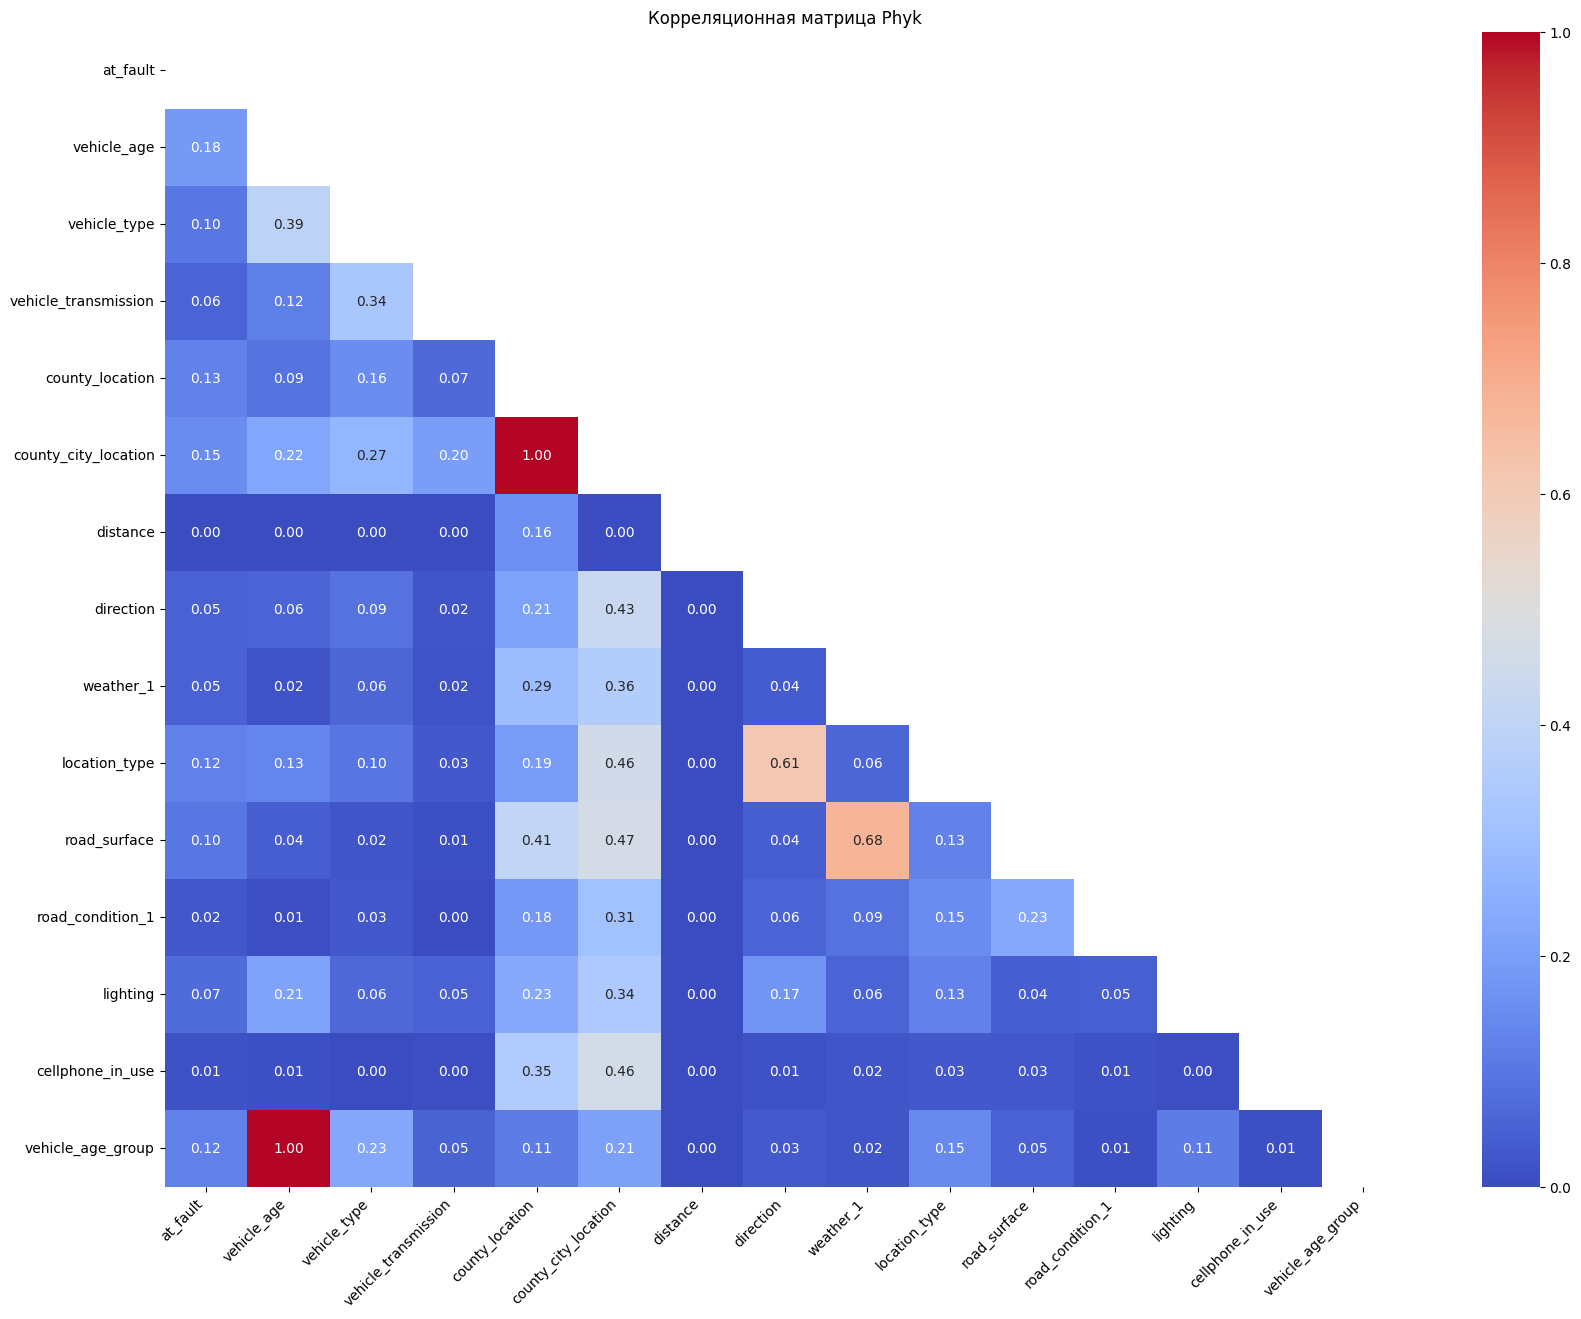

In [469]:
phik_matrix = df_fin.phik_matrix(interval_cols=int_cols)
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

Видим 100% корреляцию между созданной нами *vehicle_age_group* и *vehicle_age* что вполне естественно , а так же видим аналогичную ситуацию для *county_city_location* и *county_location*


In [470]:
df_fin.drop(['vehicle_age', 'county_location'], axis=1, inplace=True)

In [471]:
df.drop(['vehicle_age', 'county_location'], axis=1, inplace=True)

<span style="font-size:30px">**Вывод :**</span>

- Обнаружили и устранили признаки со 100% корреляцией.

- Примем решение удалить из выборки *vehicle_age* для уменьшения кол-ва признаков , а так же *county_location* как менее информативного признака чем *county_city_location*.

### Матрица для изначального датасета.

Проделаем аналогичные шаги для базового датасета но оставив в нем признаки отвечающие за трезвость водителя , для определения есть ли корреляция между ними и кол-вом аварий.

In [472]:
columns_to_drop = [col for col in to_drop_fin if col not in ['party_sobriety', 'party_drug_physical']]
columns_to_drop

['id',
 'case_id',
 'party_number',
 'primary_collision_factor',
 'pcf_violation_category',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'intersection',
 'insurance_premium',
 'control_device',
 'collision_damage']

In [473]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [474]:
df.columns

Index(['at_fault', 'vehicle_type', 'vehicle_transmission',
       'county_city_location', 'distance', 'direction', 'weather_1',
       'location_type', 'road_surface', 'road_condition_1', 'lighting',
       'party_sobriety', 'party_drug_physical', 'cellphone_in_use',
       'vehicle_age_group'],
      dtype='object')

In [475]:
int_cols = ['distance']

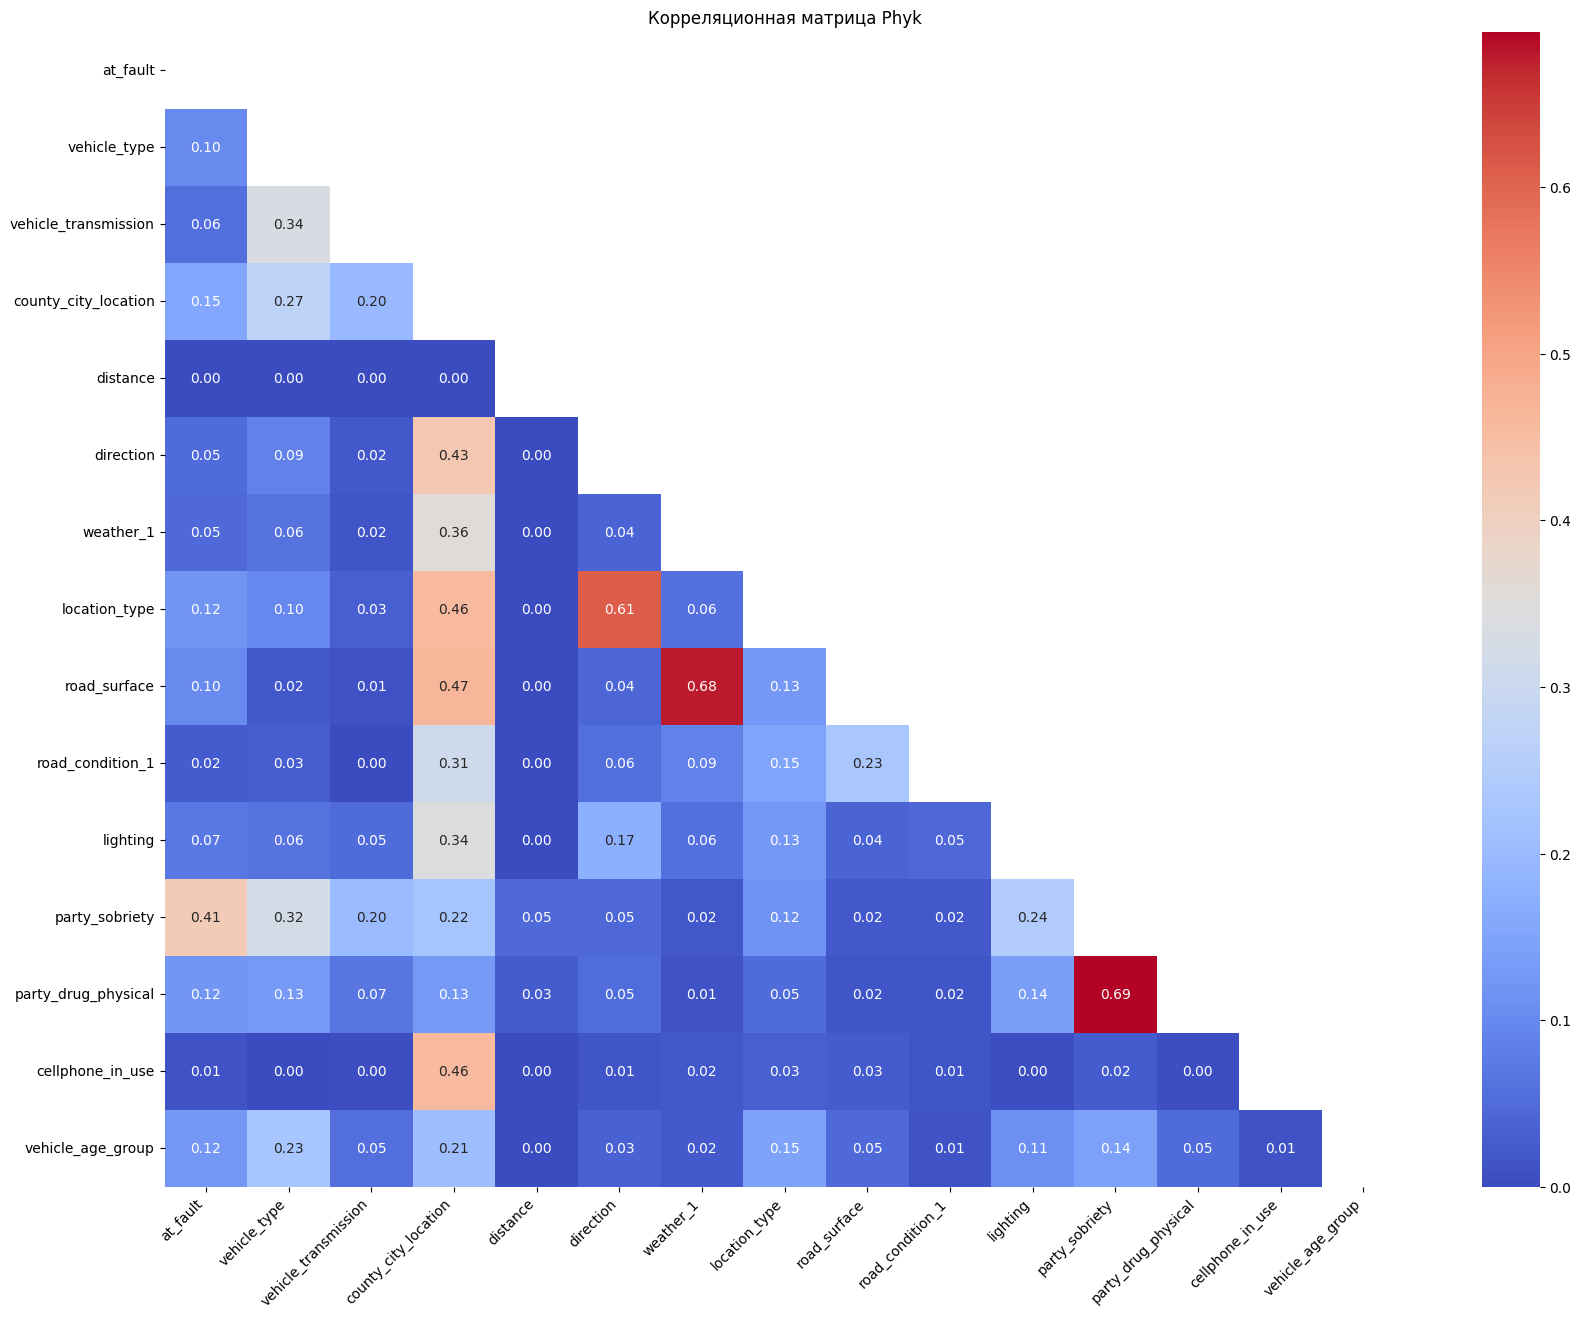

In [476]:
phik_matrix = df.phik_matrix(interval_cols=int_cols)
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

Рассмотрим как распределились значения в исследуемых нами переменных.

In [477]:
df.party_drug_physical.value_counts()

party_drug_physical
not applicable           51651
impairment unknown        1086
under drug influence       848
sleepy/fatigued            383
impairment - physical      120
Name: count, dtype: int64

In [478]:
df.party_sobriety.value_counts()

party_sobriety
had not been drinking                     46908
had been drinking, under influence         4362
impairment unknown                         1086
not applicable                              936
had been drinking, not under influence      559
had been drinking, impairment unknown       237
Name: count, dtype: int64

### Вывод

- Как видим наша изначальная догадка полностью подтвердилась для признака *party_sobriety* и в меньшей степени для *party_drug_physical*.

- Вероятно это связано с более легким способом диагностировать алкогольное опьянение , чем наличие в крови каких либо лекарств и как следствие большая часть значений в признаке *party_drug_physical* содержит **not applicable** (не оценивалось)

### Вывод

- На основании полученной матрицы корреляций мы удалили из обучающего датасета : 
    - 'vehicle_age'- заменив его категоризованной переменной для уменьшения кол-ва значений.
    - 'county_location' - так как полностью дублирует более информативный признак *county_city_location* содержащий закодированные названия городов.


- Так же рассмотрев матрицу значений *изначального* датасета , наше выдвинутое предположение о том что трезвость водителя имеет значение в причине аварий , подтвердилось.

## Создание и обучение моделей.

### Обработка типов переменных.

Перед началом обучения обработаем типы переменных , для экономии ресурсов , а так же для определения их моделями градиентного бустинга.

In [479]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54088 entries, 0 to 54553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              54088 non-null  int64   
 1   vehicle_type          54088 non-null  object  
 2   vehicle_transmission  54088 non-null  object  
 3   county_city_location  54088 non-null  object  
 4   distance              54088 non-null  float64 
 5   direction             54088 non-null  object  
 6   weather_1             54088 non-null  object  
 7   location_type         54088 non-null  object  
 8   road_surface          54088 non-null  object  
 9   road_condition_1      54088 non-null  object  
 10  lighting              54088 non-null  object  
 11  cellphone_in_use      54088 non-null  float64 
 12  vehicle_age_group     54088 non-null  category
dtypes: category(1), float64(2), int64(1), object(9)
memory usage: 7.4+ MB


Переведем все числовые переменные в том числе и содержащие категориальные переменные в тип *int64* , а данные типа *object* в *category* для возможности передачи их встроенным в модели градиентного бустинга энкодерам.

In [480]:
df_fin = df_fin.astype({col: 'category' for col in df_fin.select_dtypes(include='object').columns} | 
                {col: 'int64' for col in df_fin.select_dtypes(include='float64').columns})
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54088 entries, 0 to 54553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              54088 non-null  int64   
 1   vehicle_type          54088 non-null  category
 2   vehicle_transmission  54088 non-null  category
 3   county_city_location  54088 non-null  category
 4   distance              54088 non-null  int64   
 5   direction             54088 non-null  category
 6   weather_1             54088 non-null  category
 7   location_type         54088 non-null  category
 8   road_surface          54088 non-null  category
 9   road_condition_1      54088 non-null  category
 10  lighting              54088 non-null  category
 11  cellphone_in_use      54088 non-null  int64   
 12  vehicle_age_group     54088 non-null  category
dtypes: category(10), int64(3)
memory usage: 4.3 MB


In [481]:
df = df.astype({col: 'category' for col in df.select_dtypes(include='object').columns} | 
                {col: 'int64' for col in df.select_dtypes(include='float64').columns})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54088 entries, 0 to 54553
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              54088 non-null  int64   
 1   vehicle_type          54088 non-null  category
 2   vehicle_transmission  54088 non-null  category
 3   county_city_location  54088 non-null  category
 4   distance              54088 non-null  int64   
 5   direction             54088 non-null  category
 6   weather_1             54088 non-null  category
 7   location_type         54088 non-null  category
 8   road_surface          54088 non-null  category
 9   road_condition_1      54088 non-null  category
 10  lighting              54088 non-null  category
 11  party_sobriety        54088 non-null  category
 12  party_drug_physical   54088 non-null  category
 13  cellphone_in_use      54088 non-null  int64   
 14  vehicle_age_group     54088 non-null  category
dtypes: cate

### Baseline модели МО

#### Модель без признаков *party_sobriety* и *party_drug_physical*

In [482]:
X = df_fin.drop(['at_fault'], axis=1) 
y = df_fin['at_fault']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS, stratify=y) 
                                                
X_train.head(5)

vehicle_type vehicle_transmission county_city_location  distance  \
37047        coupe                 auto                 5201         0   
40423        coupe                 auto                 3610      1584   
4053         sedan                 auto                 3026        47   
15984        sedan                 auto                 5604         0   
39858        coupe               manual                 1400      2112   

      direction weather_1 location_type road_surface road_condition_1  \
37047       UnK     clear  intersection          dry           normal   
40423     north     clear       highway          dry     construction   
4053      south     clear           UnK          dry           normal   
15984       UnK      wind  intersection          dry           normal   
39858     south     clear           UnK          dry           normal   

                         lighting  cellphone_in_use vehicle_age_group  
37047                    daylight                 0              main  
40423                    daylight                 0              main  
4053      dark with street lights                 0              main  
15984                    daylight                 0              main  
39858  dark with no street lights                 0              main

In [483]:
y.value_counts()

at_fault
1    27362
0    26726
Name: count, dtype: int64

Видим равномерное распределение целевой переменной , но все равно применим стратификацию при создании выборок для повышения результатов модели.

In [484]:
num_cols = ['distance']

cat_cols = [
    'vehicle_type', 'vehicle_transmission',
    'direction', 'weather_1', 'location_type', 'road_surface', 
    'road_condition_1', 'lighting', 'cellphone_in_use', 'vehicle_age_group'
]

non_enc = ['county_city_location']

In [485]:
# Создадим заглущки , а параметры будем перебирать в models
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])

cat_transformer = Pipeline([
    ('encoder', 'passthrough'),  
    ('preprocessor', None)      
])

none_transformer = Pipeline([    # Отдельная обработка большого кат. признака
    ('encoder', 'passthrough'),  
    ('preprocessor', None)  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', cat_transformer, cat_cols), 
        ('none', none_transformer, non_enc)
    ],
    remainder='drop',
    transformer_weights=None)

In [486]:
models = {
    # Логистическая регрессия
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS, max_iter=1000),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')],
            'preprocessor__none__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')], 
            'regressor__C': [0.01, 0.1, 1.0],
            'regressor__solver': ['lbfgs', 'liblinear']
        }
    },
    
    # K-ближайших соседей
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__cat__encoder': [BinaryEncoder(handle_unknown='ignore'),
                                           OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
                            
            'preprocessor__none__encoder': [CountEncoder(cols=['county_city_location'],  normalize=True,                 
                                           handle_unknown='value', handle_missing='value', min_group_size=1, combine_min_nan_groups=False)], 
            'regressor__n_neighbors': [3, 5, 7],
            'regressor__weights': ['uniform', 'distance'],
            'regressor__metric': ['euclidean', 'manhattan']
        }
    },
    
    # Решающее дерево
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                           BinaryEncoder(handle_unknown='ignore'),
                                           OneHotEncoder(handle_unknown='ignore', drop='first')],
            'preprocessor__none__encoder': [CountEncoder(cols=['county_city_location'],  normalize=True,                 
                                           handle_unknown='value', handle_missing='value', min_group_size=1, combine_min_nan_groups=False)], 
            'regressor__max_depth': [3, 5, 7, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__criterion': ['gini', 'entropy']
        }
    },

    # LightGBM
    'LightGBM_categorical': {
    'model': LGBMClassifier(random_state=RS, verbose=-1),
    'params': {
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
        'preprocessor__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                       BinaryEncoder(handle_unknown='ignore'),
                                       OneHotEncoder(handle_unknown='ignore', drop='first')],
        'preprocessor__none__encoder': [CountEncoder(cols=['county_city_location'],  normalize=True,                 
                                           handle_unknown='value', handle_missing='value', min_group_size=1, combine_min_nan_groups=False)], 
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [3, 5, -1],
        'regressor__num_leaves': [31, 50]
    }
}
}

В качестве основной метрики для оценки работы модели будем использовать *recall* , учитывая поставленную задачу лучше получить несколько ложных срабатываний и выдать предупреждение , чем пропустить аварийный случай.

Так же будем использовать *precision* *roc_auc* *f1* для получения полноты картины эффективности модели.

In [487]:
%%time
results = {}
scoring_metrics = {
    'recall': 'recall',
    'precision': 'precision', 
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

CPU times: total: 0 ns
Wall time: 0 ns


In [488]:
%%time
for name, config in models.items():
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring=scoring_metrics,
        refit='recall', 
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_scores': {
            'roc_auc': cv_results[f'mean_test_roc_auc'][best_index],
            'recall': cv_results[f'mean_test_recall'][best_index],
            'precision': cv_results[f'mean_test_precision'][best_index],
            'f1': cv_results[f'mean_test_f1'][best_index]
        },
        'mean_fit_time': cv_results['mean_fit_time'].mean(), 
        'mean_score_time': cv_results['mean_score_time'].mean(),
        'full_cv_results': cv_results
    }
    
    print(f"{name} completed.")
    print(f"Best ROC-AUC: {results[name]['best_scores']['roc_auc']:.4f}")
    print(f"Best Recall: {results[name]['best_scores']['recall']:.4f}")
    print(f"Best Precision: {results[name]['best_scores']['precision']:.4f}")
    print(f"Best F1: {results[name]['best_scores']['f1']:.4f}")
    print("-" * 50)


print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for name, res in results.items():
    print(f"\n{name}:")
    print(f"Best ROC-AUC: {res['best_scores']['roc_auc']:.4f}")
    print(f"Best Recall: {res['best_scores']['recall']:.4f}")
    print(f"Best Precision: {res['best_scores']['precision']:.4f}")
    print(f"Best F1: {res['best_scores']['f1']:.4f}")
    print(f"Mean Fit Time: {res['mean_fit_time']:.2f}s")
    print(f"Mean Score Time: {res['mean_score_time']:.2f}s")
    print(f"Best Params: {res['best_params']}")
    print("-" * 80)

# Создаем DataFrame для удобного сравнения моделей

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [res['best_scores']['roc_auc'] for res in results.values()],
    'Recall': [res['best_scores']['recall'] for res in results.values()],
    'Precision': [res['best_scores']['precision'] for res in results.values()],
    'F1': [res['best_scores']['f1'] for res in results.values()],
    'Fit_Time': [res['mean_fit_time'] for res in results.values()],
    'Score_Time': [res['mean_score_time'] for res in results.values()]
})

print("\n" + "="*80)
print("COMPARISON TABLE (sorted by Recall)")
print("="*80)
print(results_df.sort_values('Recall', ascending=False).round(4))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
LogisticRegression completed.
Best ROC-AUC: 0.6384
Best Recall: 0.5826
Best Precision: 0.6062
Best F1: 0.5941
--------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits
KNN completed.
Best ROC-AUC: 0.5863
Best Recall: 0.5540
Best Precision: 0.5706
Best F1: 0.5621
--------------------------------------------------
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
DecisionTree completed.
Best ROC-AUC: 0.5483
Best Recall: 0.5076
Best Precision: 0.5471
Best F1: 0.5266
--------------------------------------------------
Fitting 5 folds for each of 144 candidates, totalling 720 fits
LightGBM_categorical completed.
Best ROC-AUC: 0.6480
Best Recall: 0.5317
Best Precision: 0.6335
Best F1: 0.5781
--------------------------------------------------

FINAL RESULTS SUMMARY

LogisticRegression:
Best ROC-AUC: 0.6384
Best Recall: 0.5826
Best Precision: 0.6062
Best F1: 0.5941
M

#### Модель с включением признаков *трезвости* пользователей.

Исключим явно известные постфактум признаки, такие как тип повреждений и тип столкновения.

Для достоверности сравнения , будем использовать аналогичные параметры при обучении моделей.

In [489]:
X_sob = df.drop(['at_fault'], axis=1) 
y_sob = df['at_fault']

X_train_sob, X_test_sob, y_train_sob, y_test_sob = train_test_split(X_sob, y_sob, test_size=0.2, random_state=RS, stratify=y) 
                                                
X_train_sob.head(5)

vehicle_type vehicle_transmission county_city_location  distance  \
37047        coupe                 auto                 5201         0   
40423        coupe                 auto                 3610      1584   
4053         sedan                 auto                 3026        47   
15984        sedan                 auto                 5604         0   
39858        coupe               manual                 1400      2112   

      direction weather_1 location_type road_surface road_condition_1  \
37047       UnK     clear  intersection          dry           normal   
40423     north     clear       highway          dry     construction   
4053      south     clear           UnK          dry           normal   
15984       UnK      wind  intersection          dry           normal   
39858     south     clear           UnK          dry           normal   

                         lighting                      party_sobriety  \
37047                    daylight               had not been drinking   
40423                    daylight               had not been drinking   
4053      dark with street lights  had been drinking, under influence   
15984                    daylight               had not been drinking   
39858  dark with no street lights  had been drinking, under influence   

      party_drug_physical  cellphone_in_use vehicle_age_group  
37047      not applicable                 0              main  
40423      not applicable                 0              main  
4053       not applicable                 0              main  
15984      not applicable                 0              main  
39858      not applicable                 0              main

In [490]:
num_cols = ['distance']

cat_cols = [
    'vehicle_type', 'vehicle_transmission', 'party_sobriety', 'party_drug_physical',
    'direction', 'weather_1', 'location_type', 'road_surface', 
    'road_condition_1', 'lighting', 'cellphone_in_use', 'vehicle_age_group'
]

non_enc = ['county_city_location']

In [491]:
# Создадим заглущки , а параметры будем перебирать в models
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])

cat_transformer = Pipeline([
    ('encoder', 'passthrough'),  
    ('preprocessor', None)      
])

none_transformer = Pipeline([    # Отдельная обработка большого кат. признака
    ('encoder', 'passthrough'),  
    ('preprocessor', None)  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', cat_transformer, cat_cols), 
        ('none', none_transformer, non_enc)
    ],
    remainder='drop',
    transformer_weights=None)

In [492]:
%%time
results_sober = {}
scoring_metrics = {
    'recall': 'recall',
    'precision': 'precision', 
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

for name, config in models.items():
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring=scoring_metrics,
        refit='recall', 
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_sob, y_train_sob)
    
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    
    results_sober[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_scores': {
            'roc_auc': cv_results[f'mean_test_roc_auc'][best_index],
            'recall': cv_results[f'mean_test_recall'][best_index],
            'precision': cv_results[f'mean_test_precision'][best_index],
            'f1': cv_results[f'mean_test_f1'][best_index]
        },
        'mean_fit_time': cv_results['mean_fit_time'].mean(), 
        'mean_score_time': cv_results['mean_score_time'].mean(),
        'full_cv_results': cv_results
    }
    
    print(f"{name} completed.")
    print(f"Best ROC-AUC: {results_sober[name]['best_scores']['roc_auc']:.4f}")
    print(f"Best Recall: {results_sober[name]['best_scores']['recall']:.4f}")
    print(f"Best Precision: {results_sober[name]['best_scores']['precision']:.4f}")
    print(f"Best F1: {results_sober[name]['best_scores']['f1']:.4f}")
    print("-" * 50)


print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for name, res in results_sober.items():
    print(f"\n{name}:")
    print(f"Best ROC-AUC: {res['best_scores']['roc_auc']:.4f}")
    print(f"Best Recall: {res['best_scores']['recall']:.4f}")
    print(f"Best Precision: {res['best_scores']['precision']:.4f}")
    print(f"Best F1: {res['best_scores']['f1']:.4f}")
    print(f"Mean Fit Time: {res['mean_fit_time']:.2f}s")
    print(f"Mean Score Time: {res['mean_score_time']:.2f}s")
    print(f"Best Params: {res['best_params']}")
    print("-" * 80)

# Создаем DataFrame для удобного сравнения моделей

results_sober_df = pd.DataFrame({
    'Model': list(results_sober.keys()),
    'ROC-AUC': [res['best_scores']['roc_auc'] for res in results_sober.values()],
    'Recall': [res['best_scores']['recall'] for res in results_sober.values()],
    'Precision': [res['best_scores']['precision'] for res in results_sober.values()],
    'F1': [res['best_scores']['f1'] for res in results_sober.values()],
    'Fit_Time': [res['mean_fit_time'] for res in results_sober.values()],
    'Score_Time': [res['mean_score_time'] for res in results_sober.values()]
})

print("\n" + "="*80)
print("COMPARISON TABLE (sorted by Recall)")
print("="*80)
print(results_sober_df.sort_values('Recall', ascending=False).round(4))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
LogisticRegression completed.
Best ROC-AUC: 0.6833
Best Recall: 0.5281
Best Precision: 0.6765
Best F1: 0.5931
--------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits
KNN completed.
Best ROC-AUC: 0.6089
Best Recall: 0.5597
Best Precision: 0.5894
Best F1: 0.5742
--------------------------------------------------
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
DecisionTree completed.
Best ROC-AUC: 0.5682
Best Recall: 0.5451
Best Precision: 0.5796
Best F1: 0.5617
--------------------------------------------------
Fitting 5 folds for each of 144 candidates, totalling 720 fits
LightGBM_categorical completed.
Best ROC-AUC: 0.6916
Best Recall: 0.5020
Best Precision: 0.7075
Best F1: 0.5873
--------------------------------------------------

FINAL RESULTS SUMMARY

LogisticRegression:
Best ROC-AUC: 0.6833
Best Recall: 0.5281
Best Precision: 0.6765
Best F1: 0.5931
M

#### Сравнительный анализ

In [493]:
results_df.sort_values('Recall', ascending=False)

Model   ROC-AUC    Recall  Precision        F1  Fit_Time  \
0    LogisticRegression  0.638436  0.582576   0.606197  0.594130  0.733204   
1                   KNN  0.586342  0.553977   0.570561  0.562117  0.426092   
3  LightGBM_categorical  0.648017  0.531728   0.633507  0.578102  4.975393   
2          DecisionTree  0.548347  0.507606   0.547051  0.526559  0.693124   

   Score_Time  
0    0.142603  
1   11.606644  
3    0.145500  
2    0.160072

In [494]:
results_sober_df.sort_values('Recall', ascending=False)

Model   ROC-AUC    Recall  Precision        F1  Fit_Time  \
1                   KNN  0.608922  0.559688   0.589424  0.574151  0.525135   
2          DecisionTree  0.568217  0.545068   0.579611  0.561750  0.864535   
0    LogisticRegression  0.683292  0.528074   0.676491  0.593116  1.105523   
3  LightGBM_categorical  0.691574  0.502033   0.707499  0.587276  4.594167   

   Score_Time  
1   16.172785  
2    0.194894  
0    0.189654  
3    0.152612

Видим что включение признаков трезвости даже известных перед поездкой не сильно влияют на выбранную нами метрику *Recall* (Возможно из за небольшого кол-ва подтвержденных случаев).

Вместо этого дополнительные данные повышают *Precission* и *ROC-AUC* что говорит нам что модель начинает лучше предсказывать объекты класса *0*.

#### Сравнение модели с случайным предсказанием.

Мы получили не самую лучшее значение метрики Recall на тестовых данных в 0.58 , что не сильно лучше случайного угадывания.

Для этого мы проведем сравнительный анализ с моделью случайного предсказания.

In [495]:
model = results['LogisticRegression']['best_model']

In [496]:
X_train_dum = model['preprocessor'].transform(X_train) # скорей всего лишнее , но так для справедливости решил сделать

In [497]:
dummy_stratified = DummyClassifier(strategy='stratified', random_state=RS)
dummy_stratified.fit(X_train_dum, y_train) 

DummyClassifier(random_state=42, strategy='stratified')

In [498]:
y_pred_dum = dummy_stratified.predict(X_test)

In [499]:
print(f'Метрика Recall на модели со случайным предсказанием : {recall_score(y_pred_dum, y_test):.2f}') 
print(f'Метрика Recall на базовой модели LogisticRegression : {results_df.loc[0][2]:.2f}') 


Метрика Recall на модели со случайным предсказанием : 0.50
Метрика Recall на базовой модели LogisticRegression : 0.58


<span style="font-size:30px">**Вывод :**</span>

- Мы видим что наша модель в своей базовой версии без смещения порога срабатывания , немногим лучше чем DummyClassifier , 0.58 против 0.5 по метрике Recall.

- В блоке ниже постараемся подобрать порог срабатывания для улучшения нашей основной метрики.


#### Подбор порога срабатывания.

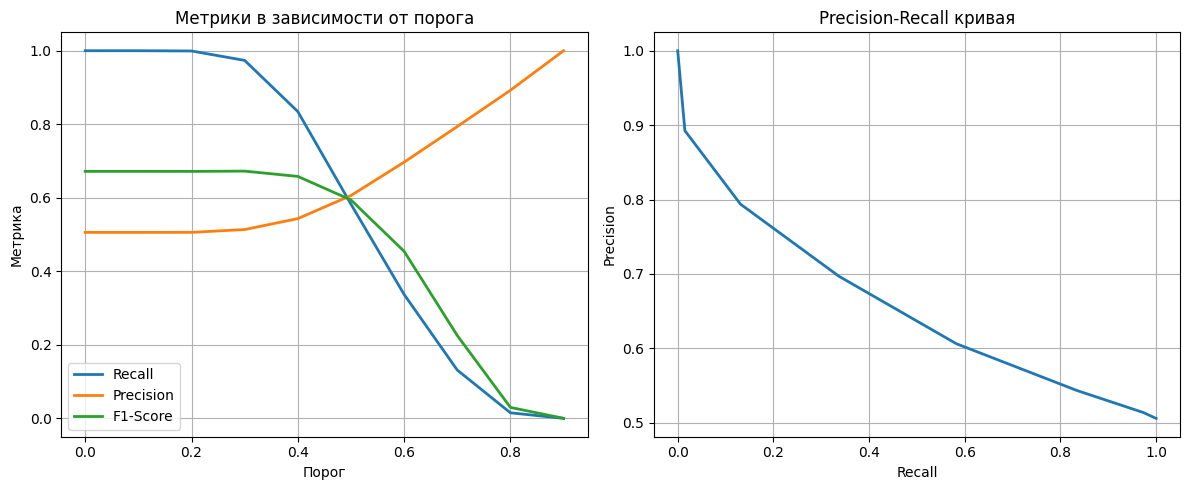

In [500]:
y_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')

y_scores = y_proba[:, 1]

thresholds = np.arange(0.0, 1.0, 0.1)
recalls = []
precisions = []
f1_scoress = []

for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    
    recall = recall_score(y_train, y_pred, zero_division=0)
    precision = precision_score(y_train, y_pred, zero_division=0)
    
    recalls.append(recall)
    precisions.append(precision)
    
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scoress.append(f1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, f1_scoress, label='F1-Score', linewidth=2)
plt.xlabel('Порог')
plt.ylabel('Метрика')
plt.title('Метрики в зависимости от порога')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.grid(True)

plt.tight_layout()
plt.show()


In [501]:
target_recall = 0.90  # например, хотим recall >= 80%

valid_indices = [i for i, r in enumerate(recalls) if r >= target_recall]

if valid_indices:
    best_idx = max(valid_indices, key=lambda i: precisions[i])
    best_threshold = thresholds[best_idx]
    
    print(f"Для recall >= {target_recall}:")
    print(f"Оптимальный порог: {best_threshold:.3f}")
    print(f"Recall: {recalls[best_idx]:.3f}")
    print(f"Precision: {precisions[best_idx]:.3f}")
    print(f"F1-Score: {f1_scoress[best_idx]:.3f}")
else:
    print(f"Невозможно достичь recall >= {target_recall}")


Для recall >= 0.9:
Оптимальный порог: 0.300
Recall: 0.974
Precision: 0.514
F1-Score: 0.673


In [502]:
thresholds = np.arange(0.1, 0.9, 0.02)
min_precision = 0.3 
best_threshold = 0.5
best_recall = 0

for threshold in thresholds:
    y_pred_custom = (y_scores >= threshold).astype(int)
    
    recall = recall_score(y_train, y_pred_custom)
    precision = precision_score(y_train, y_pred_custom)
    
    if precision >= min_precision and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
    
    print(f"Threshold: {threshold:.2f}, Recall: {recall:.3f}, Precision: {precision:.3f}")


Threshold: 0.10, Recall: 1.000, Precision: 0.506
Threshold: 0.12, Recall: 1.000, Precision: 0.506
Threshold: 0.14, Recall: 1.000, Precision: 0.506
Threshold: 0.16, Recall: 1.000, Precision: 0.506
Threshold: 0.18, Recall: 1.000, Precision: 0.506
Threshold: 0.20, Recall: 0.999, Precision: 0.506
Threshold: 0.22, Recall: 0.998, Precision: 0.506
Threshold: 0.24, Recall: 0.995, Precision: 0.507
Threshold: 0.26, Recall: 0.991, Precision: 0.509
Threshold: 0.28, Recall: 0.984, Precision: 0.511
Threshold: 0.30, Recall: 0.974, Precision: 0.514
Threshold: 0.32, Recall: 0.959, Precision: 0.518
Threshold: 0.34, Recall: 0.938, Precision: 0.522
Threshold: 0.36, Recall: 0.910, Precision: 0.528
Threshold: 0.38, Recall: 0.878, Precision: 0.535
Threshold: 0.40, Recall: 0.834, Precision: 0.543
Threshold: 0.42, Recall: 0.792, Precision: 0.553
Threshold: 0.44, Recall: 0.742, Precision: 0.563
Threshold: 0.46, Recall: 0.688, Precision: 0.578
Threshold: 0.48, Recall: 0.635, Precision: 0.591
Threshold: 0.50, Rec

In [503]:
best_threshold = 0.36 # Выберем этот порог , при более низких предсказание 0-класса скатывается близко в нулю.

y_pred_custom = (y_scores >= best_threshold).astype(int)


print("Результаты с кастомным порогом:")
print(classification_report(y_train, y_pred_custom))

Результаты с кастомным порогом:
              precision    recall  f1-score   support

           0       0.64      0.17      0.26     21381
           1       0.53      0.91      0.67     21889

    accuracy                           0.54     43270
   macro avg       0.59      0.54      0.47     43270
weighted avg       0.59      0.54      0.47     43270



<span style="font-size:30px">**Вывод :**</span>

- Мы провели тестирование возможных порогов и остановились на оптимальном значении в 0.4 , удалось добиться значений recall=0.90 при сохранении precision=0.52.

#### Проверка модели на тестовых данных и оценка матрицы ошибок.

In [504]:
best_threshold = 0.36
y_pred_standard = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:,1]
y_pred_custom = (y_scores >= best_threshold).astype(int)

In [505]:
metrics_comparison = pd.DataFrame({
    'Метрики': ['Recall', 'Precision', 'ROC-AUC', 'F1-Score'],
    'Базовая версия': [
        recall_score(y_test, y_pred_standard),
        precision_score(y_test, y_pred_standard),
        roc_auc_score(y_test, y_pred_standard),
        f1_score(y_test, y_pred_standard)
    ],
    'Версия со смещенным порогом': [
        recall_score(y_test, y_pred_custom),
        precision_score(y_test, y_pred_custom),
        roc_auc_score(y_test, y_pred_standard),
        f1_score(y_test, y_pred_custom)
    ]
}).set_index('Метрики')

metrics_comparison.round(4)

Базовая версия  Версия со смещенным порогом
Метрики                                               
Recall             0.5792                       0.9103
Precision          0.6074                       0.5297
ROC-AUC            0.5979                       0.5979
F1-Score           0.5930                       0.6697

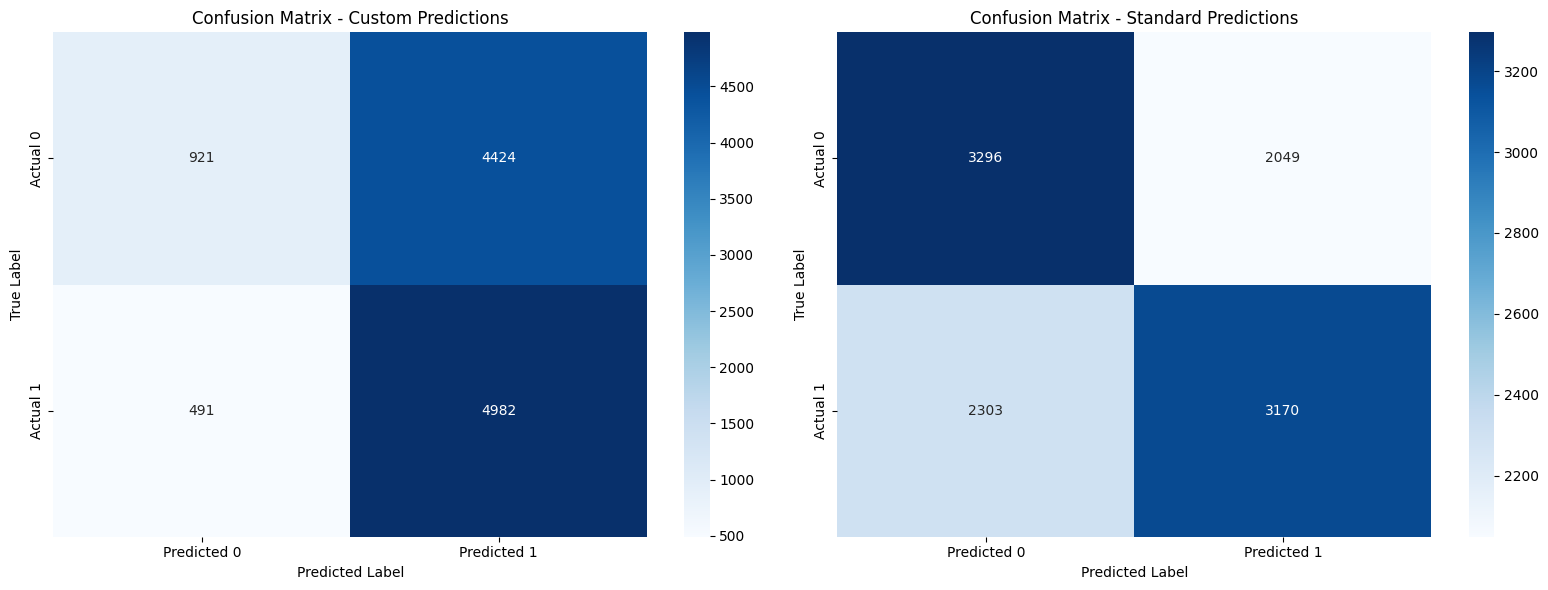

In [506]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Первый confusion matrix cмещенный
cm1 = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=ax1)
ax1.set_title('Confusion Matrix - Custom Predictions')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Второй confusion matrix standart
cm2 = confusion_matrix(y_test, y_pred_standard)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], ax=ax2)
ax2.set_title('Confusion Matrix - Standard Predictions')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

**True Negative (TN) = 902**

Модель правильно определила отсутствие аварийной ситуации. Пользователь выбрал максимально безопасный маршрут согласно модели.

**False Negative (FN) = 545**

Это те случаи когда модель посчитала маршрут полностью безопасным , а авария случилась по вине нашего пользователя.


**False Positive (FP) = 4483**

Вероятность аварии по предсказаниям модели была минимальной. Но изменив порог чувствительности , модель предупредит пользователя о возможной опасности. Что повысит внимательность водителя и снизит риск потенциального ДТП.


**True Positive (TP) = 4952**

Это те случаи где модель увидела опасность ДТП и заблаговременно предупредила пользователя , но авария все равно произошла.

**Recall**(Полнота) в 0.9 значит что модель в своем текущем состоянии будет выдавать предупреждение в 90% случаев.

**Precission**(Точность) показывает насколько это предсказание сходится с имеющимися данными. Полученное нами значение в 0.52 можно интерпретировать как то что почти в половина выданных предупреждений будет ложными.


Так как мы разрабатываем модель для снижения кол-ва потенциальных ДТП , эти значения метрик вполне допустимы.

Нам удалось повысить предсказание действительно случившихся аварий с 3172 до 4928 и повысить кол-во рекомендательных предупрежденией с 2111 до 4443 по сравнению с базовой версией модели.

### Вывод

- Мы вели наше исследование в двух направлениях с использованием заранее известной информации о трезвости водителей и без. И пришли к выводу что такая информация в оказывает незначительное влияние на выбранную нами метрику Recall.
В свою очередь эта информация помогла бы определить *виновность* пользователя в случившимся ДТП.


- В базовой версии модели наша метрика качества достигла значения в 0.58


- Мы провели сравнительный анализ с моделью случайного предсказания значения которой составили 0.5 по метрику Recall , видим что наша модель со значением 0.58 работает немного лучше.


- Нами было принято решение изменить порог чувствительности модели для повышения частоты выдачи предупреждений. Протестировав разные значения порога , мы остановились на значении в 0.36.


- Применив новые значения модели , мы провели проверку на тестовых данных и получили улучшений метрики Recall до 0.9 при сохранении значения Precission в 0.52.


- Проанализировав матрицу ошибок , мы увидели увеличение действительно правильно предсказанных аварийных случаев , а так же кол-во рекомендательных(ложных) срабатываний.

## Анализ основных факторов на которые опиралась модель при предсказании.

Получим значение весов встроенным в модель способом.

In [507]:
feature_names = model['preprocessor'].get_feature_names_out()
coefficients = model['regressor'].coef_[0]
feature_importance_coef = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_importance': np.abs(coefficients)
}).sort_values('abs_importance', ascending=False)

feature_importance_coef.sort_values('abs_importance', ascending=False)

feature  coefficient  abs_importance
2            cat__vehicle_type_sedan    -0.778309        0.778309
19           cat__road_surface_snowy     0.716124        0.716124
131  none__county_city_location_1700     0.639042        0.639042
455  none__county_city_location_4500     0.594104        0.594104
34    cat__vehicle_age_group_premium     0.586645        0.586645
..                               ...          ...             ...
490  none__county_city_location_5101    -0.001339        0.001339
508  none__county_city_location_5603    -0.001049        0.001049
245  none__county_city_location_2700     0.000949        0.000949
64   none__county_city_location_0700     0.000611        0.000611
477  none__county_city_location_4907     0.000267        0.000267

[524 rows x 3 columns]

Видим что модель отдает предпочтение таким признакам как *distance* *road_surface* *vehicle_age* *lighning*

Применим альтернативную методику поиска значимости признаков , использовав библиотеку SHAP

In [508]:
feature_names = model['preprocessor'].get_feature_names_out()
final_model = model.named_steps['regressor']  

X_train_transformed = model.named_steps['preprocessor'].transform(X_train)  
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
    
explainer = shap.LinearExplainer(final_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_transformed)

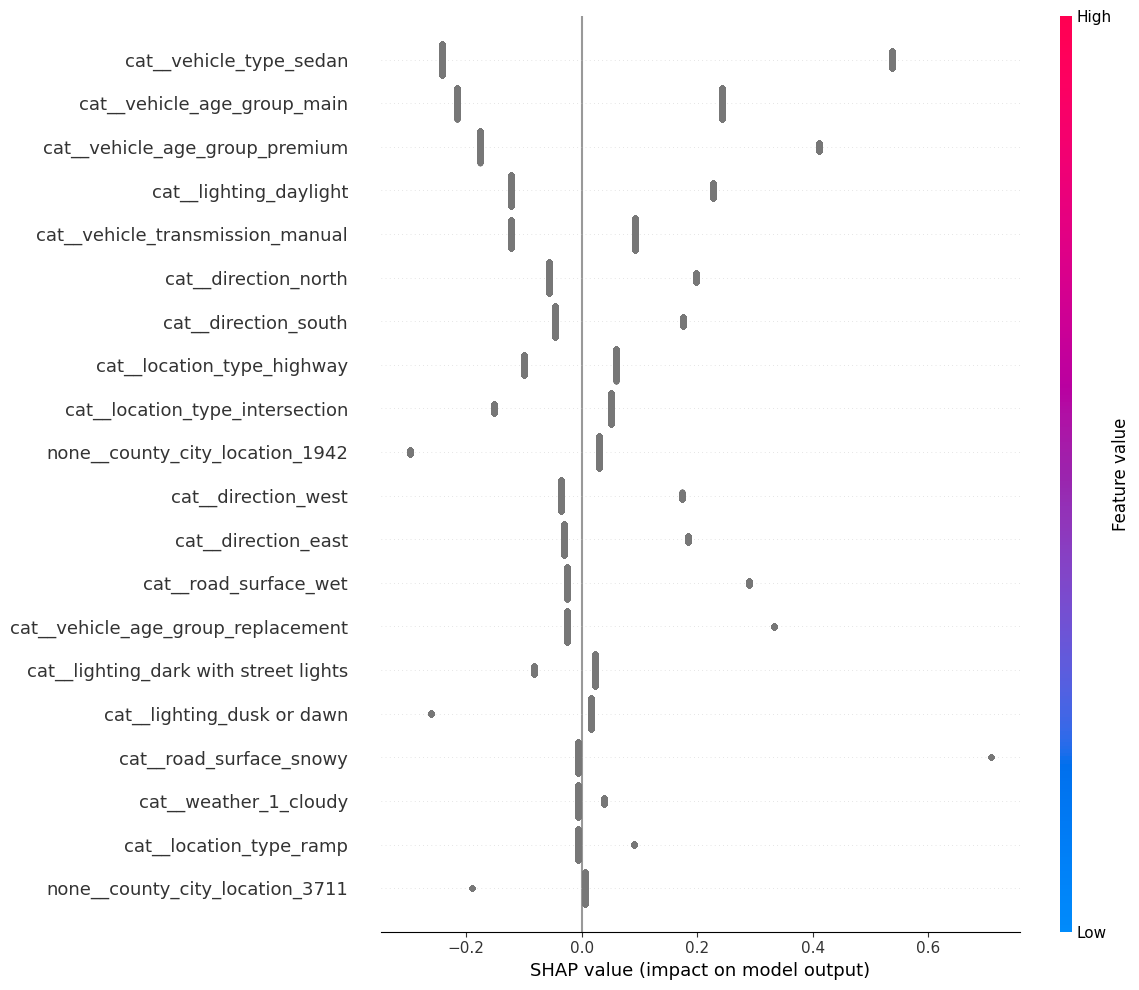

In [509]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="dot", show=False, plot_size=(12,10))


In [510]:
explainer = shap.LinearExplainer(final_model, X_train_transformed, feature_names=feature_names)
explanation = explainer(X_test_transformed)

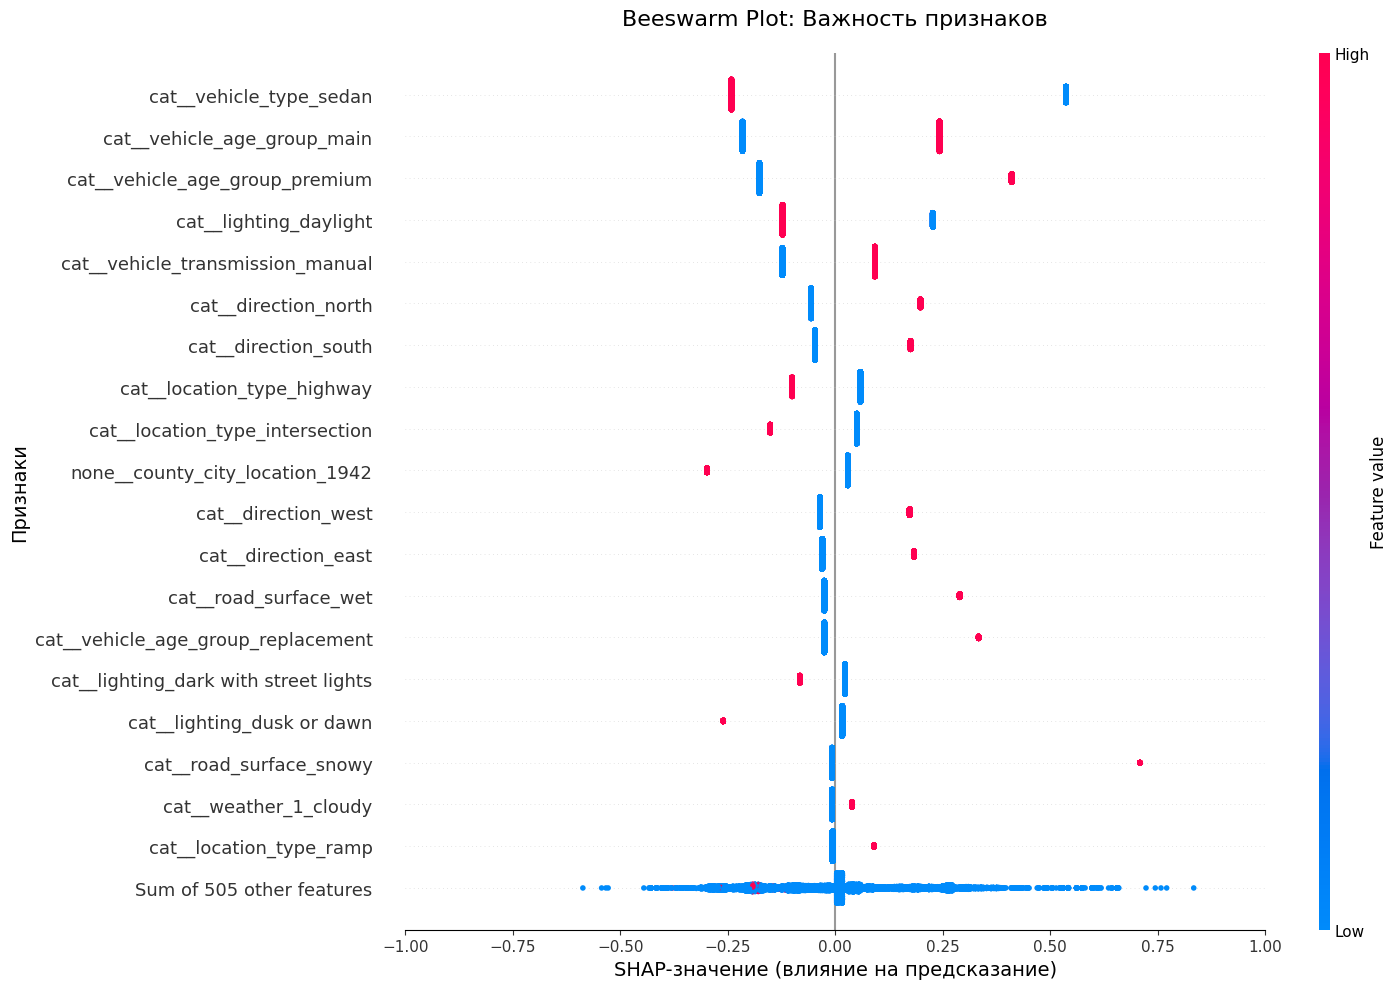

In [511]:
fig, ax = plt.subplots(figsize=(15,10))  

shap.plots.beeswarm(explanation, show=False, plot_size=(15,10), max_display=20)
ax.set_xlim(-1, 1)

ax.set_title("Beeswarm Plot: Важность признаков", fontsize=16, pad=20)
ax.set_xlabel("SHAP-значение (влияние на предсказание)", fontsize=14)
ax.set_ylabel("Признаки", fontsize=14)

plt.tight_layout() 
plt.show()

Анализ при помощи SHAP в целом подтверждает полученные на прямую коэффициенты и выводы , но удалось заметить следующие интересные закономерности :

- Видим что на новых машинах пользователи чаще попадают в ДТП , возможно это связанно с тем что они находятся в более *свежем* техническом состоянии и позволяют разгонятся до высокой скорости быстрей и легче , что и подталкивает водителей к нарушению ПДД.

Видим что основными факторами выступили :

- Освещенность

- Дистанция до главной дороги

- Тип и возраст авто

- Тип местности и дороги.

Проанализируем один из основных факторов , а именно признак отвечающий за освещенность простроив график зависимости с целевой переменной.

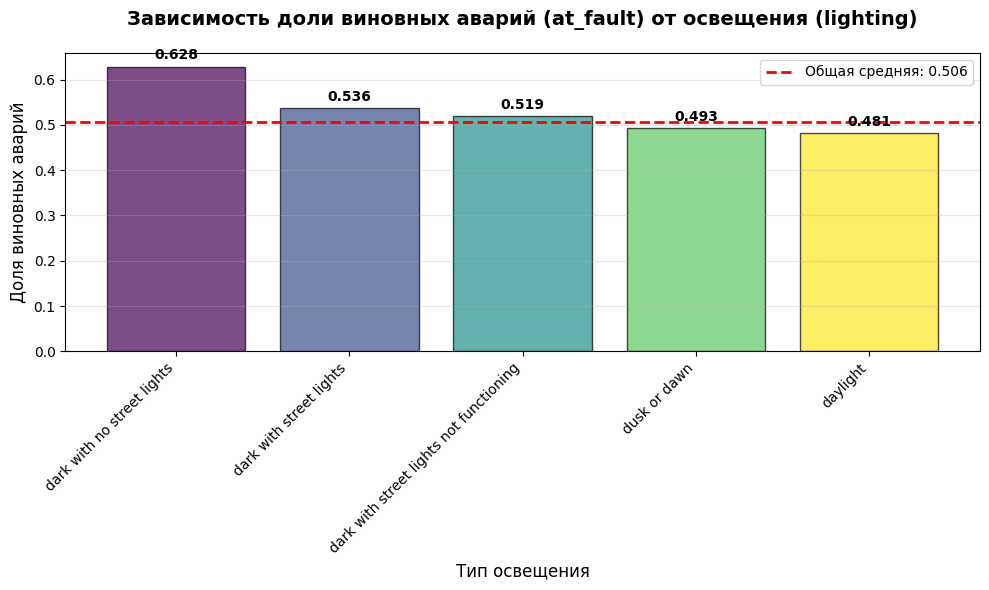

ДЕТАЛЬНАЯ СТАТИСТИКА ПО lighting:
dark with no street lights:
  - Доля виновных в авариях: 0.628 (62.8%)
  - Количество наблюдений: 5040.0
  - Отклонение от общего среднего: +0.122

dark with street lights:
  - Доля виновных в авариях: 0.536 (53.6%)
  - Количество наблюдений: 10494.0
  - Отклонение от общего среднего: +0.031

dark with street lights not functioning:
  - Доля виновных в авариях: 0.519 (51.9%)
  - Количество наблюдений: 131.0
  - Отклонение от общего среднего: +0.013

dusk or dawn:
  - Доля виновных в авариях: 0.493 (49.3%)
  - Количество наблюдений: 1699.0
  - Отклонение от общего среднего: -0.013

daylight:
  - Доля виновных в авариях: 0.481 (48.1%)
  - Количество наблюдений: 36724.0
  - Отклонение от общего среднего: -0.025



In [513]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

plt.figure(figsize=(10, 6))

lighting_at_fault = df_fin.groupby('lighting')['at_fault'].agg(['mean', 'count']).sort_values('mean', ascending=False)

bars = plt.bar(lighting_at_fault.index, lighting_at_fault['mean'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(lighting_at_fault))),
               alpha=0.7, edgecolor='black')

for i, (idx, row) in enumerate(lighting_at_fault.iterrows()):
    plt.text(i, row['mean'] + 0.01, f'{row["mean"]:.3f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.title('Зависимость доли виновных аварий (at_fault) от освещения (lighting)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Тип освещения', fontsize=12)
plt.ylabel('Доля виновных аварий', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

overall_mean = df_fin['at_fault'].mean()
plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=2, 
            label=f'Общая средняя: {overall_mean:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print("ДЕТАЛЬНАЯ СТАТИСТИКА ПО lighting:")
print("=" * 50)
for lighting_type, row in lighting_at_fault.iterrows():
    print(f"{lighting_type}:")
    print(f"  - Доля виновных в авариях: {row['mean']:.3f} ({row['mean']*100:.1f}%)")
    print(f"  - Количество наблюдений: {row['count']}")
    print(f"  - Отклонение от общего среднего: {row['mean'] - overall_mean:+.3f}")
    print()

<span style="font-size:30px">**Вывод :**</span>

- Проведенный анализ выявил прямую зависимость между уровнем освещенности и количеством ДТП. Эта взаимосвязь усиливается другими ключевыми факторами — расстоянием до главной дороги (distance) и типом местности (location_type).

- Таким образом, можно заключить, что риск аварии в темное время суток значительно возрастает при удалении от крупных магистралей, которые, как правило, хорошо освещены и имеют качественное дорожное покрытие.- 

- В качестве мер для снижения аварийности предлагается:

    - Интегрировать в автомобили навигационные системы, которые будут рекомендовать маршруты преимущественно по крупным, хорошо освещенным дорогам.

    - Рассмотреть возможность замены штатных фар на более мощные для улучшения видимости на неосвещенных участках.

## Финальный вывод и рекомендации.

К нам обратилась каршеринговой компании с просьбой разработать модель, которая могла бы оценить риск ДТП по выбранному маршруту движения. Во что мы сделали в рамках этой задачи :


- Выполнили подключение и ознакомление с базой заказчика. Убедились в возможности объединения таблиц по ключу *case_id*.


- Провели статистический анализ ДТП в разрезе времени года и установили что риск возникновения повышается в зимний период с ухудшением условий дорожного покрытия.


- Сформулировали и определили дальнейшие шаги для нашей команды. Взяв в работу некоторые из них мы установили что :

    - Что основным фактором ДТП является нарушение правил ПДД , а так же что виновность *не трезвых* пользователей достигает практически 100%.


    - Так же мы обнаружили что основная часть ДТП связана с автомобилями возрастом *3-5лет*. Но из за того что в базе отсутствует описание автопарка заказчика , сделать какие либо выводы мы не можем , возможно что большая часть авто просто представлена этой группой и является технически исправной.


- Мы выполнили формирование и выгрузку данных соответствующих требованиям заказчика.


- Выполнили разведывательный анализ и обработку обнаруженных дефектов в данных , в основном заполнив пропуски доступными средствами.


- Провели отбор признаков по доступности перед поездкой. А так же составили датасет где присутствовали данные о трезвости пользователей , для оценки релевантности внедрения встроенных в систему авто анализаторов алкоголя.


- Провели обучения двух моделей. Использовав метрику recall для оценки эффективности. По результатам сравнительного анализа удалось колебания нашей метрики были незначительные, что говорит о крайне низкой эффективности данных о трезвости если бы у нас была возможность их получения перед поездкой. При сравнении с моделью случайного предсказания , наша модель показала себя немного лучше , показал recall=0.58 против recall=0.5.


- Так же мы выполнили корректировку порога срабатывания модели , повысив метрику recall до 0.90 при сохранении precission равным 0.52.


- Оценили вклад каждого признака в предсказание модели и установили что такие признаки как *освещенность и удаленность от главной дороги* играют решающее значение. Мы связали это с тем что удаление от главных магистралей в темное время суток напрямую вляет на освещенность и качество дорожного полотна , что увеличивает риск ДТП.


- Без смещения уровня порога срабатывания , внедрение модели по предсказанию ДТП выглядит не целесообразным. Так как в возникновении ДТП участвуют большое кол-во недоступных при аренде автомобиля факторов , таких как состояние других участников движения , погода и т.д. Достоверное предсказание ДТП не представляется возможным.


<span style="font-size:25px">**Рекомендации**</span>

- Из установленной нами связи заказчику следует обратить внимание на : 

    - Интеграцию в автомобили навигационные системы, которые будут рекомендовать маршруты преимущественно по крупным, хорошо освещенным дорогам.

    - Рассмотреть возможность замены штатных фар на более мощные для улучшения видимости на неосвещенных участках.